In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.ensemble import RandomForestRegressor

In [159]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')

In [160]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# T2B5

In [161]:
T2B5 = record[record.Standard == 'T2B5'].RecordID.values
T2B5 = [str(i).zfill(9) for i in T2B5]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T2B5[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T2B5[0]]*len(df)
for record in T2B5[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df.dropna()
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

# 'NOx_ppm'

In [162]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

In [163]:
# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

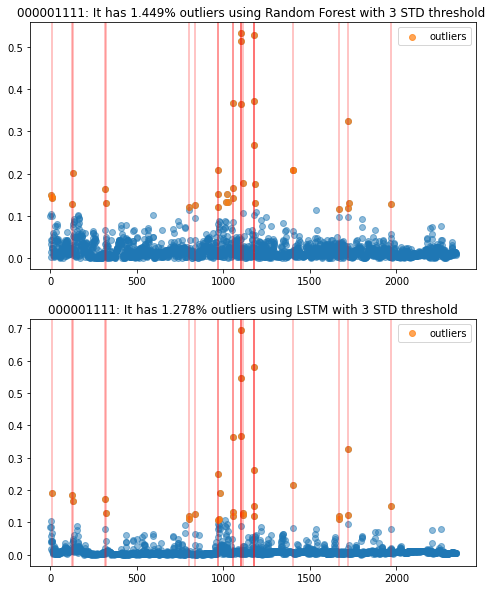

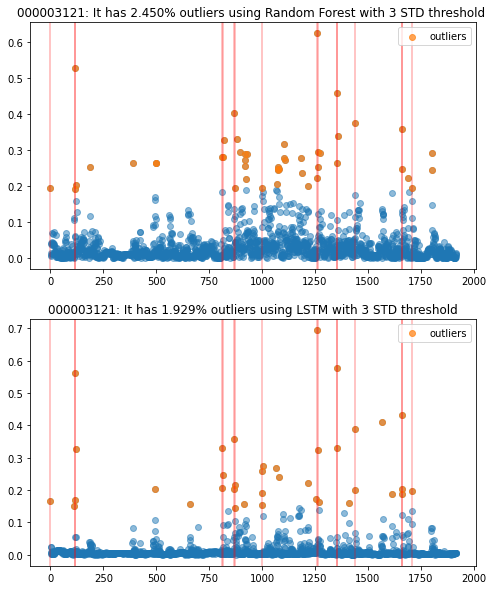

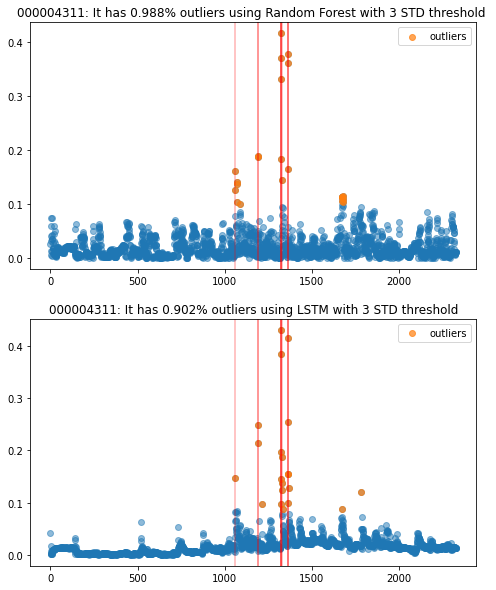

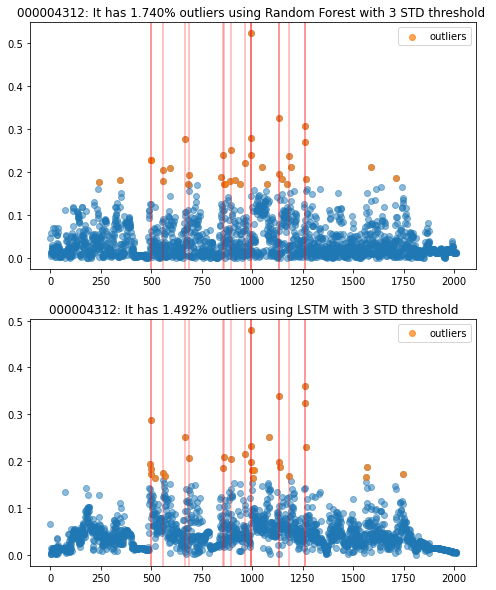

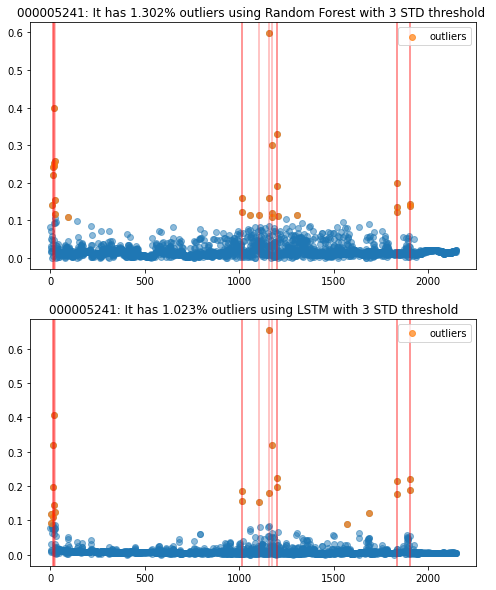

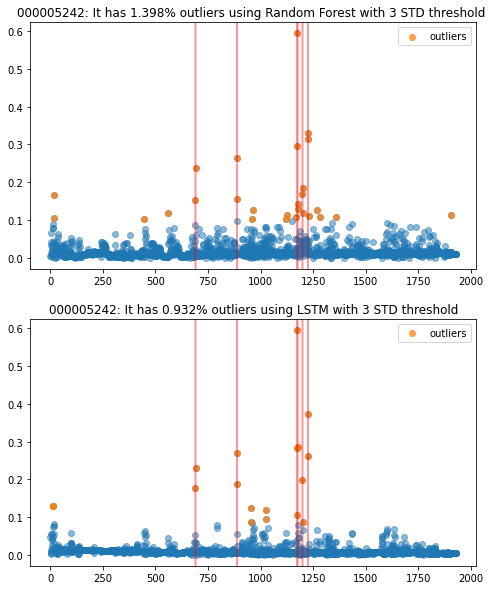

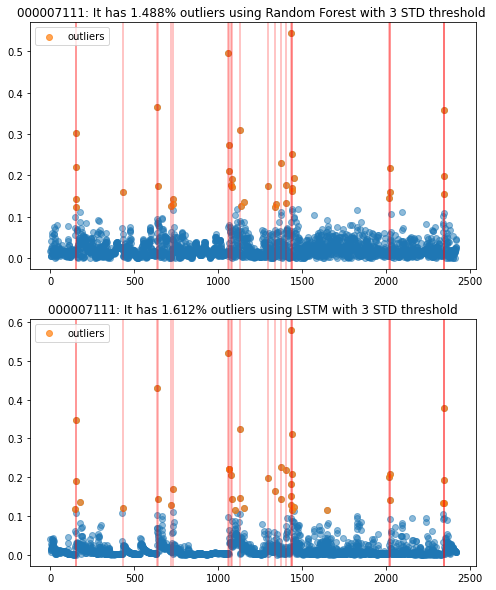

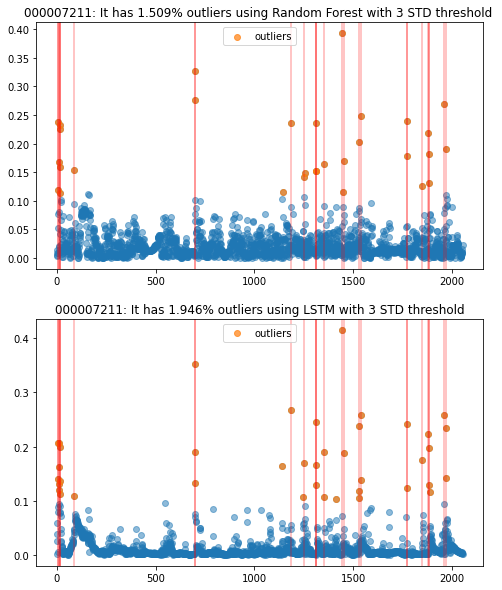

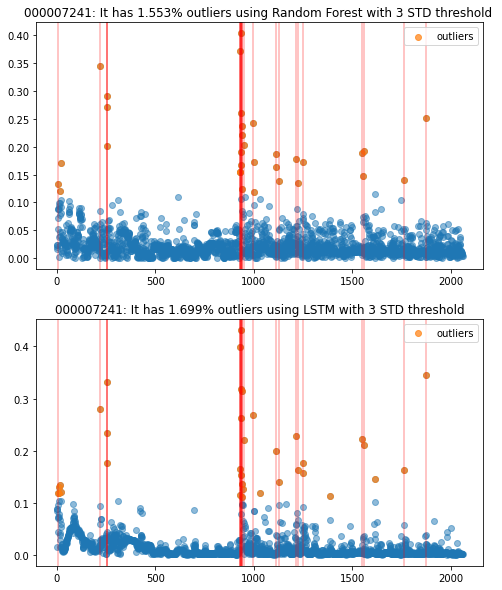

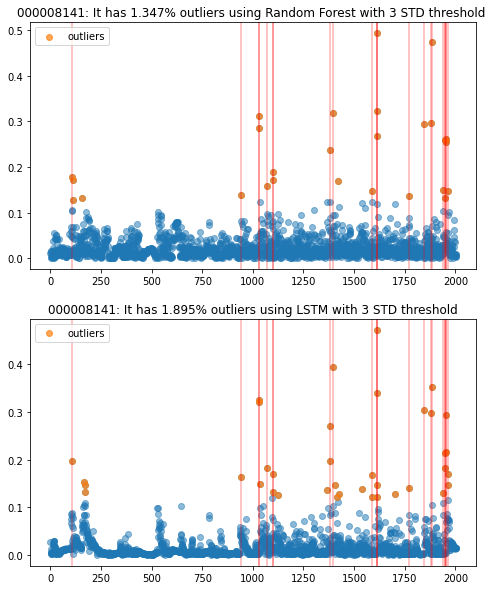

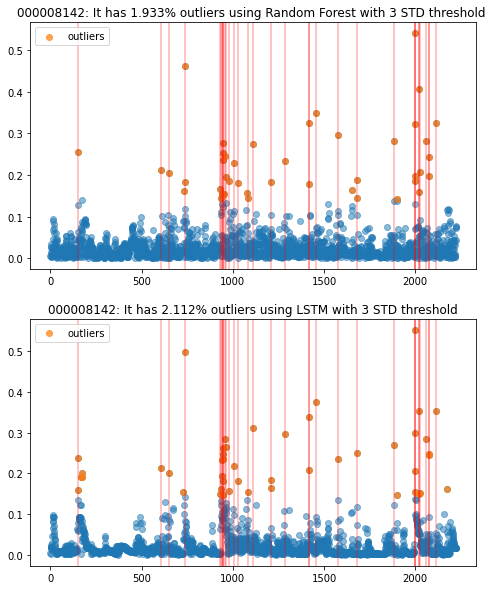

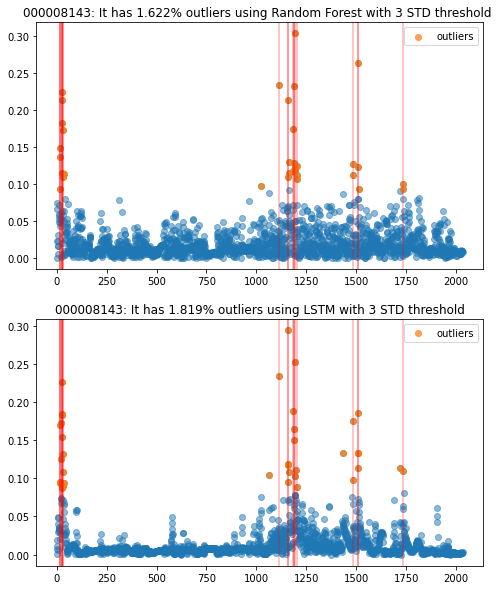

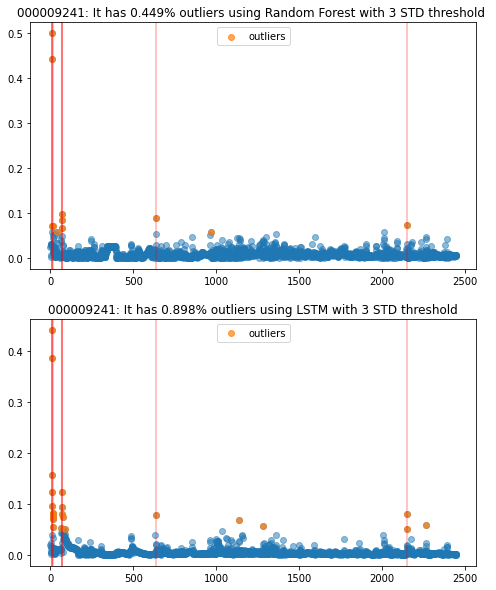

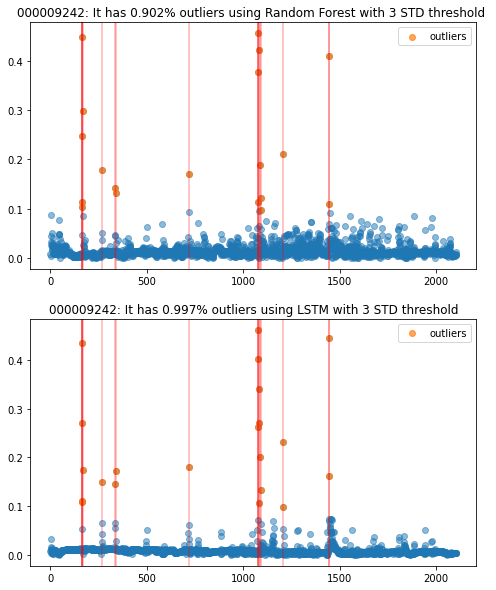

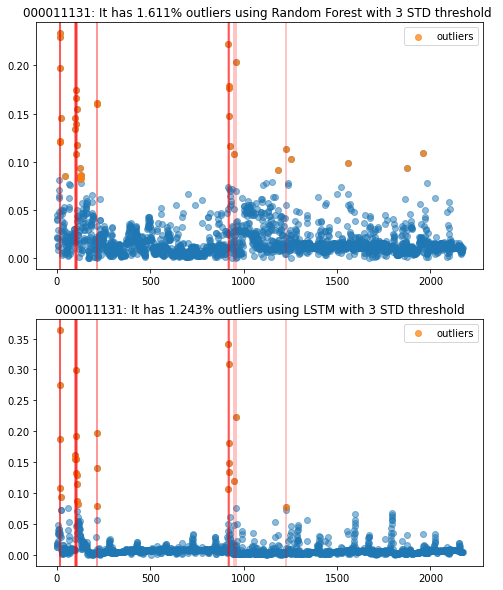

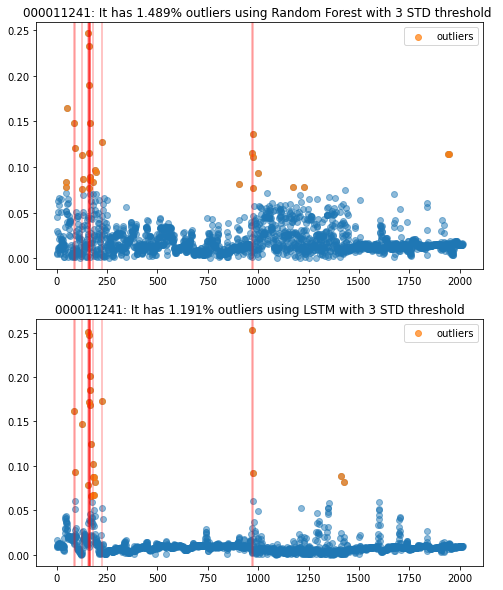

In [164]:
ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T2B5:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()


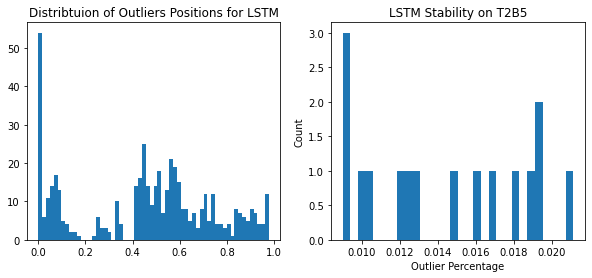

In [165]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T2B5')
plt.show()

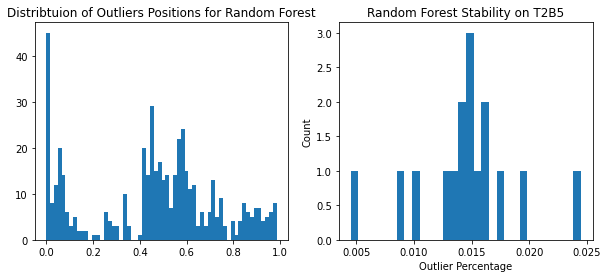

In [166]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T2B5')
plt.show()

In [167]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000008142', 0.021123595505617977),
 ('000007211', 0.019464720194647202),
 ('000003121', 0.01929092805005214),
 ('000008141', 0.018952618453865335),
 ('000008143', 0.018190757128810225),
 ('000007241', 0.01699029126213592),
 ('000007111', 0.016122364613476645),
 ('000004312', 0.014917951268025857),
 ('000001111', 0.01278227524499361),
 ('000011131', 0.012425218591808559),
 ('000011241', 0.011910669975186104),
 ('000005241', 0.010232558139534883),
 ('000009242', 0.009971509971509971),
 ('000005242', 0.009316770186335404),
 ('000004311', 0.00902061855670103),
 ('000009241', 0.00898325847284606)]

In [168]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000003121', 0.024504692387904068),
 ('000008142', 0.019325842696629212),
 ('000004312', 0.0174042764793635),
 ('000008143', 0.016224188790560472),
 ('000011131', 0.016106764841233318),
 ('000007241', 0.015533980582524271),
 ('000007211', 0.01508515815085158),
 ('000011241', 0.01488833746898263),
 ('000007111', 0.014882182720132286),
 ('000001111', 0.014486578610992756),
 ('000005242', 0.013975155279503106),
 ('000008141', 0.013466334164588529),
 ('000005241', 0.013023255813953489),
 ('000004311', 0.009879725085910653),
 ('000009242', 0.009021842355175688),
 ('000009241', 0.00449162923642303)]

choose 000008142

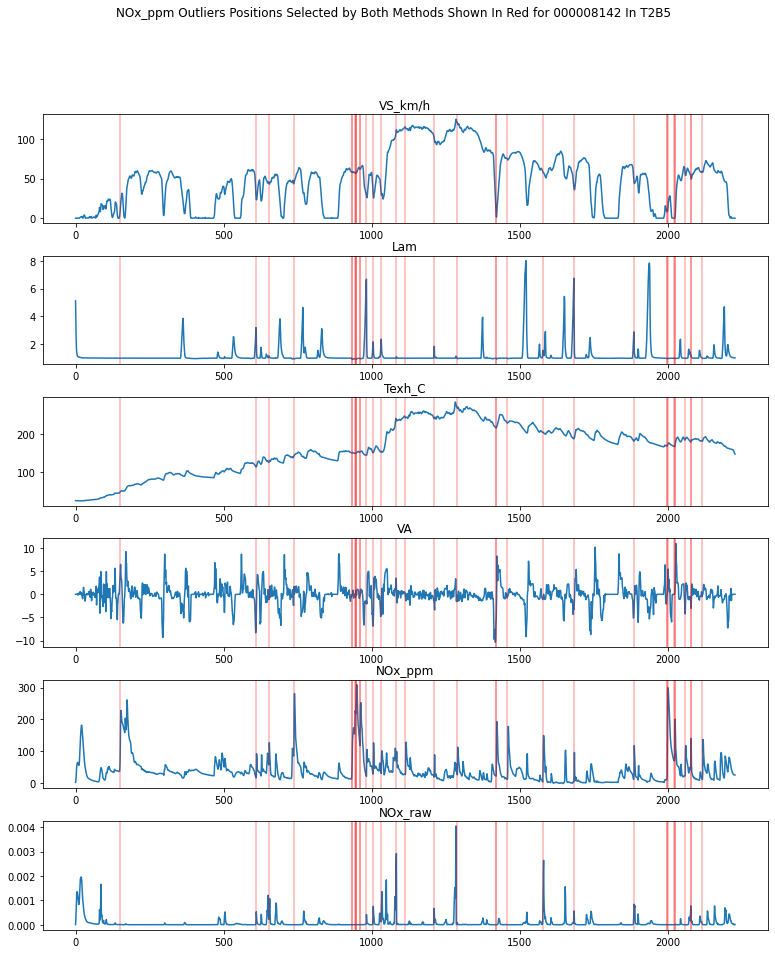

In [169]:
record = '000008142'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T2B5")
plt.show()

# 'NOx_raw'

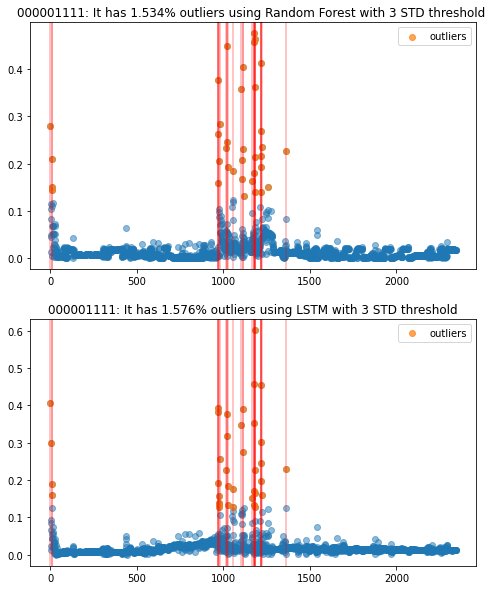

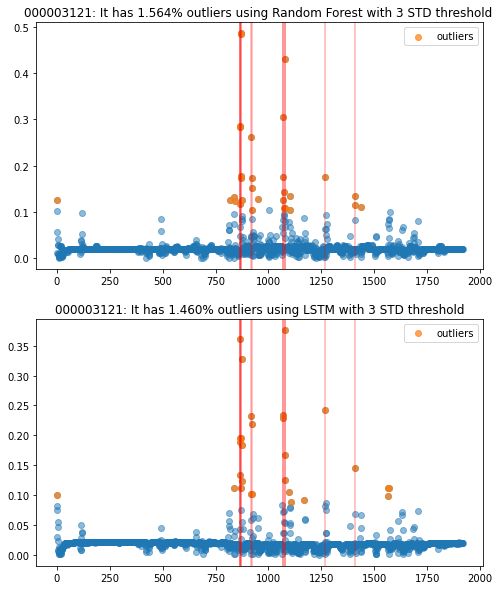

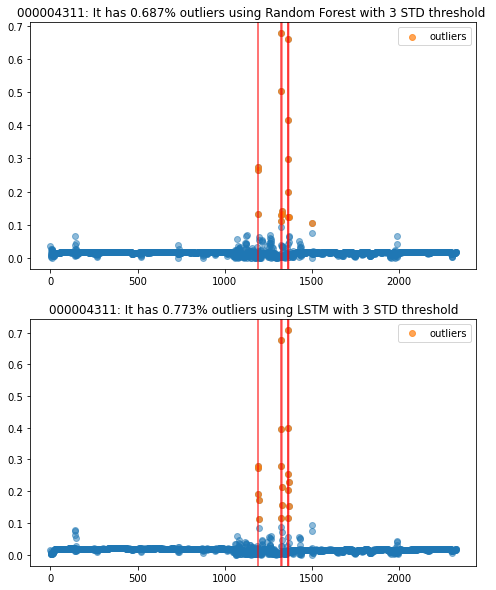

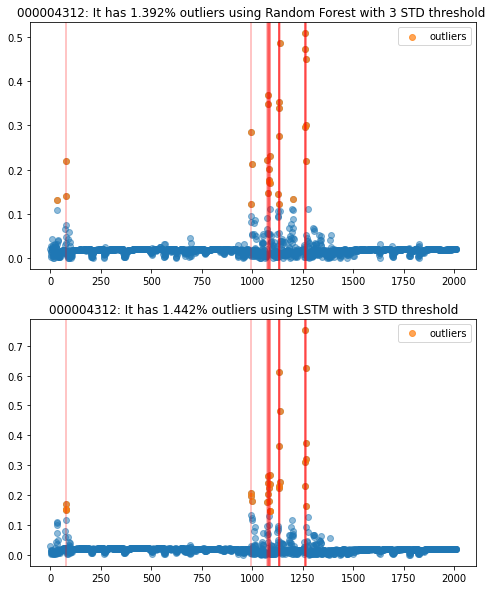

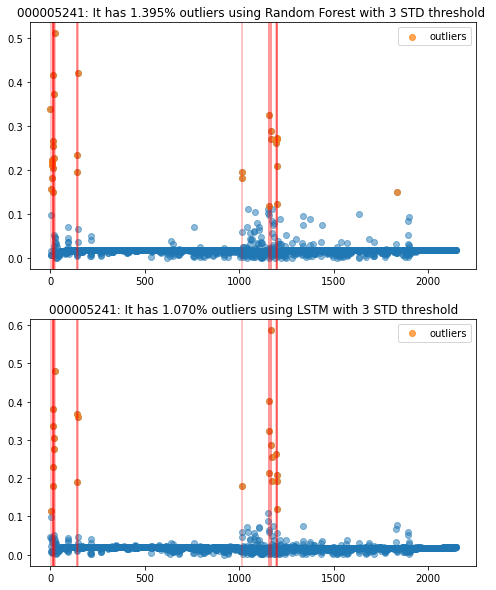

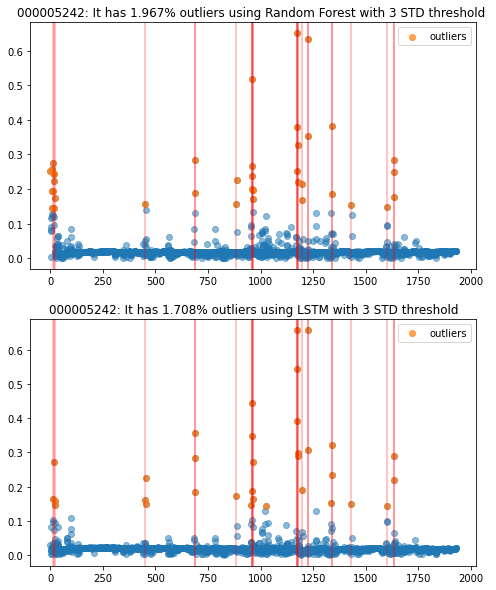

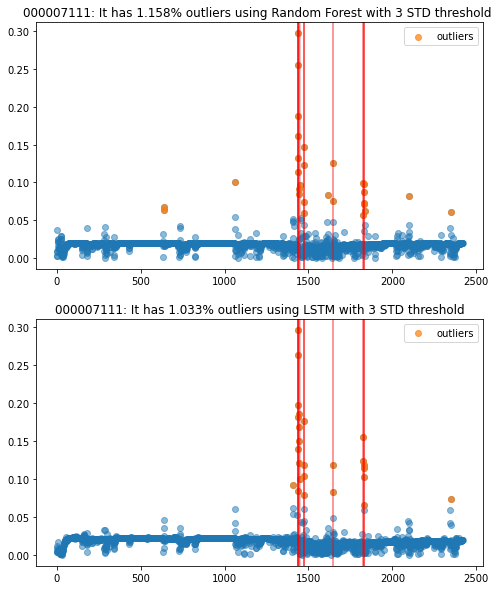

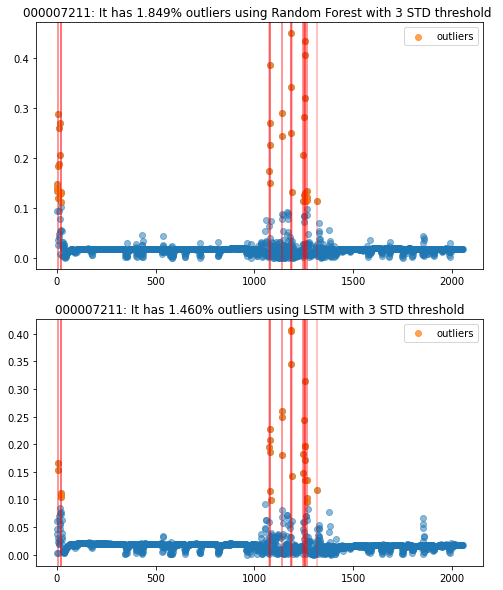

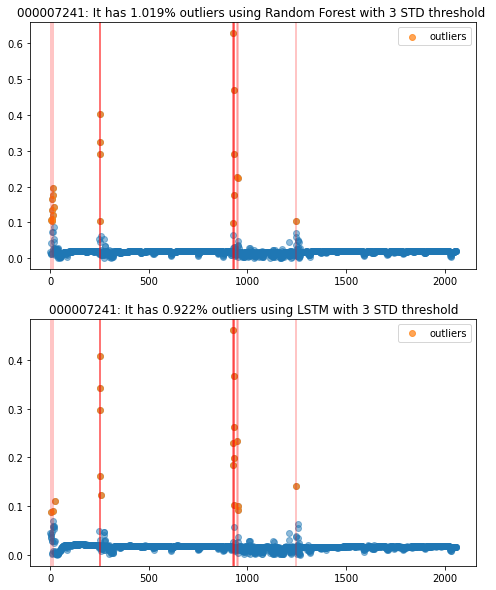

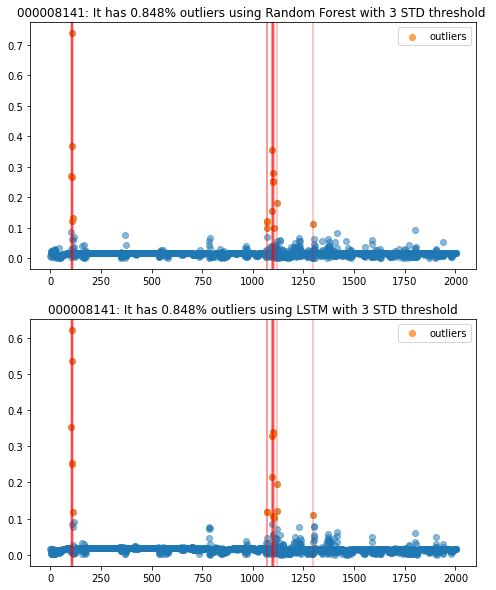

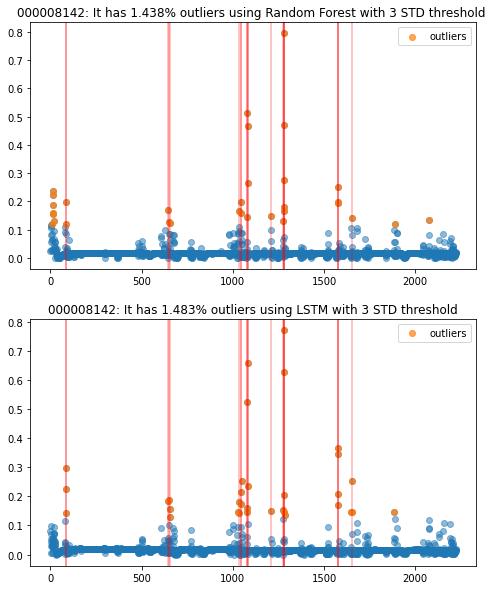

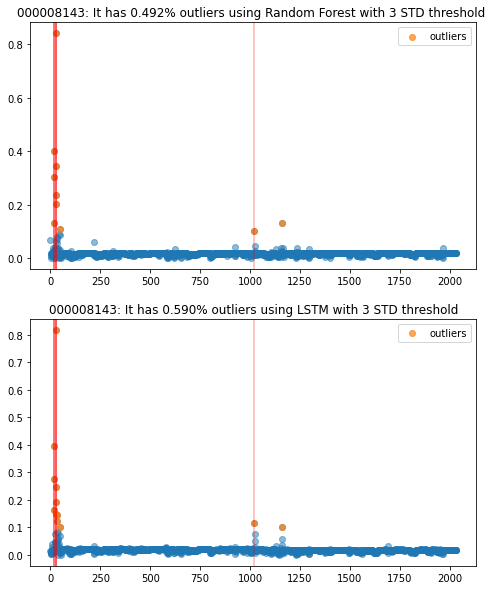

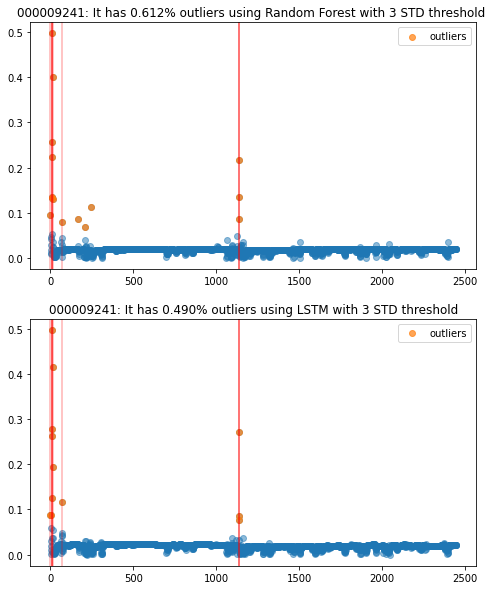

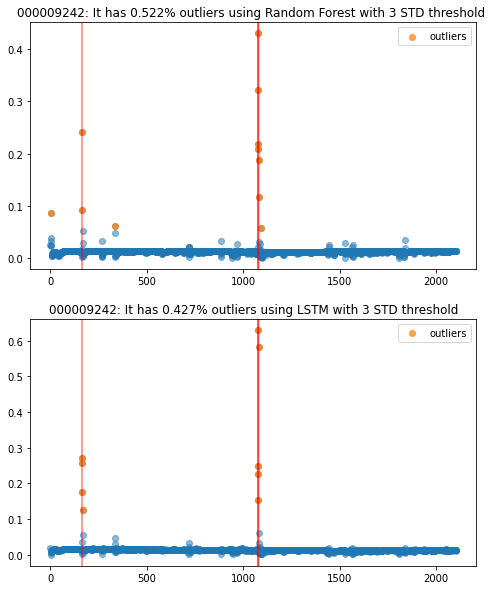

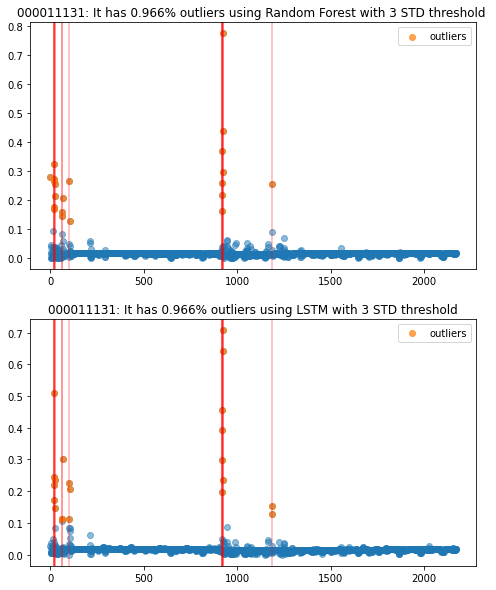

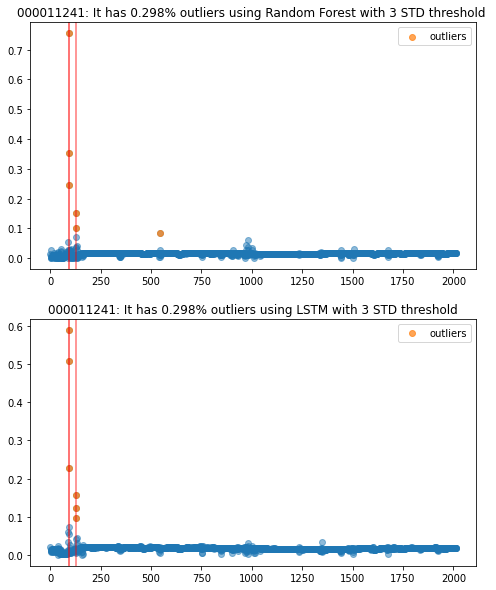

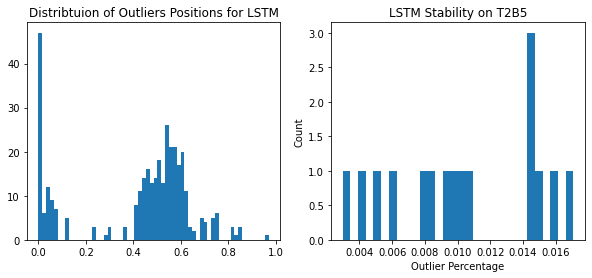

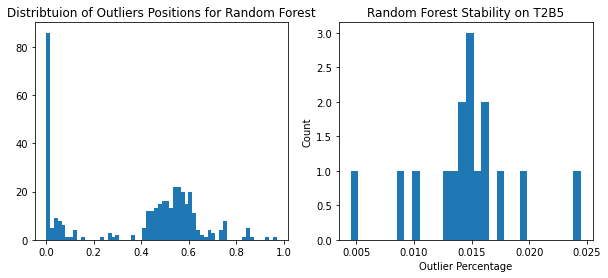

In [170]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T2B5:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T2B5')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T2B5')
plt.show()

In [171]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000005242', 0.017080745341614908),
 ('000001111', 0.015764806135492117),
 ('000008142', 0.014831460674157304),
 ('000003121', 0.014598540145985401),
 ('000007211', 0.014598540145985401),
 ('000004312', 0.014420686225758329),
 ('000005241', 0.010697674418604652),
 ('000007111', 0.010334849111202976),
 ('000011131', 0.009664058904739991),
 ('000007241', 0.009223300970873786),
 ('000008141', 0.008478802992518703),
 ('000004311', 0.007731958762886598),
 ('000008143', 0.0058997050147492625),
 ('000009241', 0.004899959167006942),
 ('000009242', 0.004273504273504274),
 ('000011241', 0.002977667493796526)]

In [172]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000005242', 0.019668737060041408),
 ('000007211', 0.018491484184914843),
 ('000003121', 0.01564129301355579),
 ('000001111', 0.01533873029399233),
 ('000008142', 0.014382022471910113),
 ('000005241', 0.013953488372093023),
 ('000004312', 0.0139234211834908),
 ('000007111', 0.011575031004547334),
 ('000007241', 0.010194174757281554),
 ('000011131', 0.009664058904739991),
 ('000008141', 0.008478802992518703),
 ('000004311', 0.006872852233676976),
 ('000009241', 0.006124948958758677),
 ('000009242', 0.0052231718898385565),
 ('000008143', 0.004916420845624385),
 ('000011241', 0.002977667493796526)]

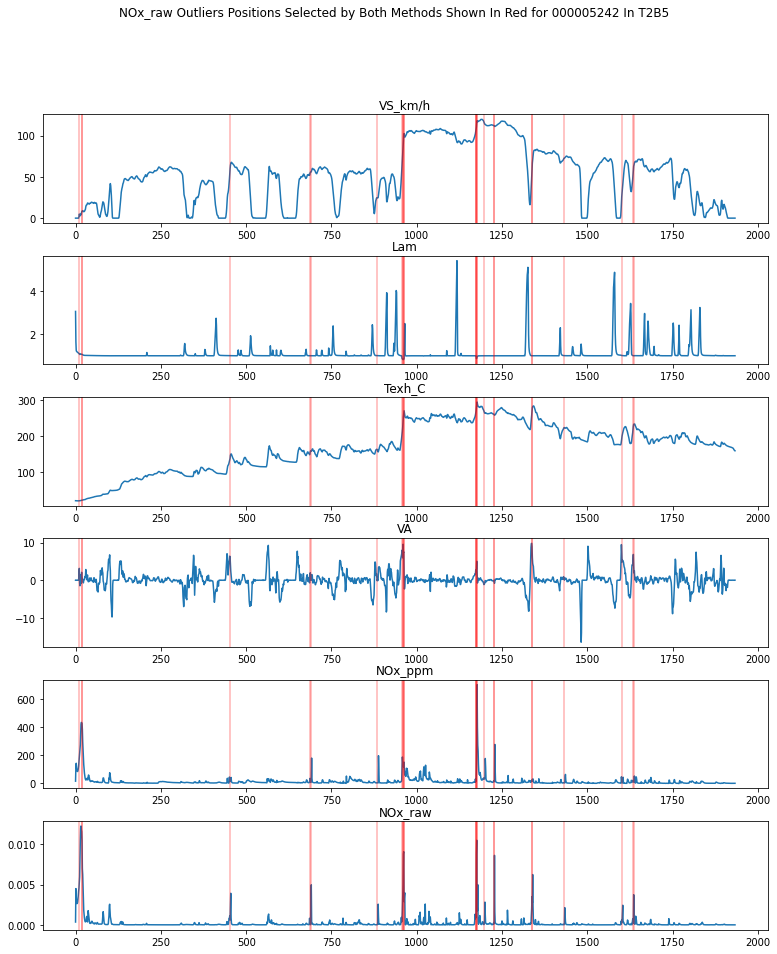

In [173]:
record = '000005242'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T2B5")
plt.show()

# T2B4

In [174]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T2B4 = record[record.Standard == 'T2B4'].RecordID.values
T2B4 = [str(i).zfill(9) for i in T2B4]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T2B4[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T2B4[0]]*len(df)
for record in T2B4[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df.dropna()
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

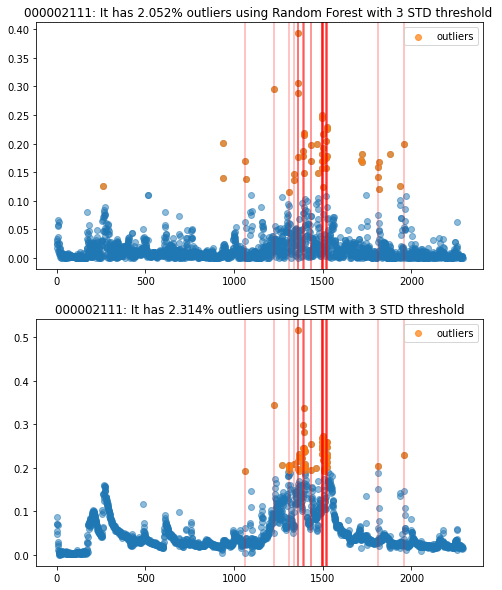

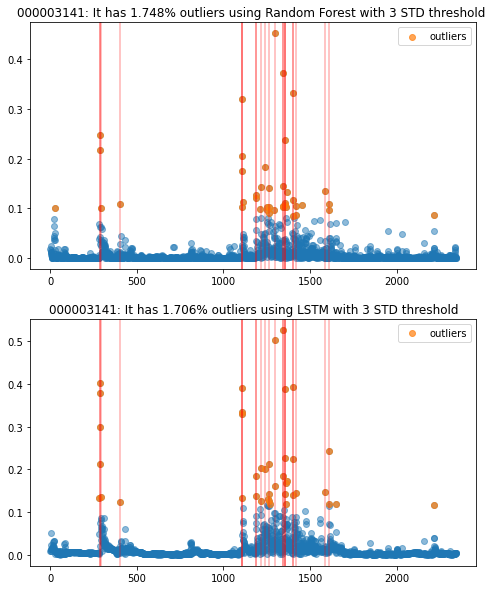

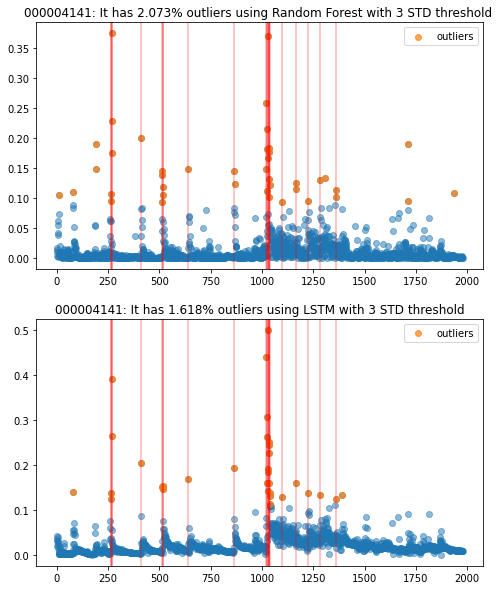

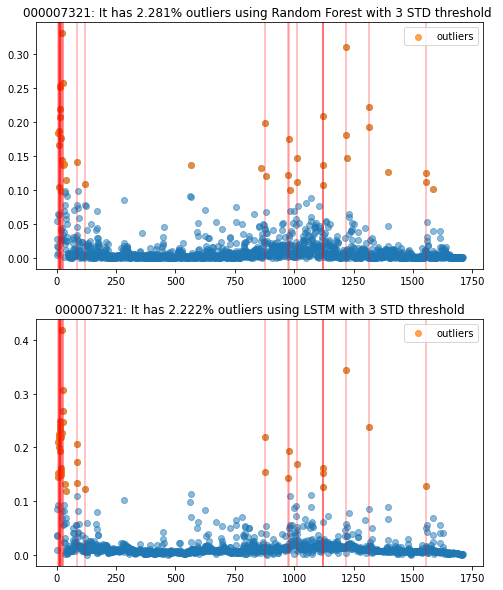

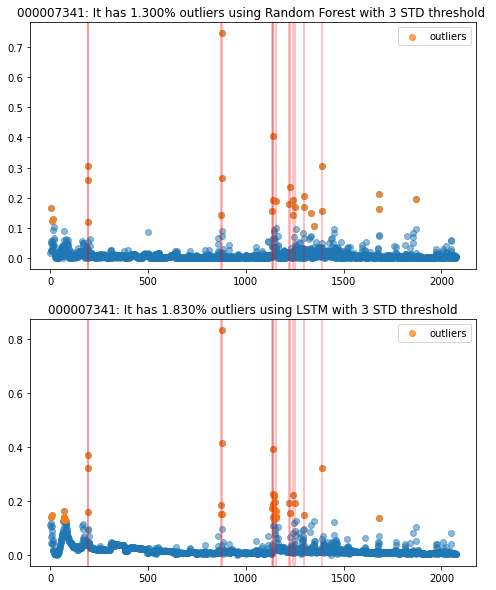

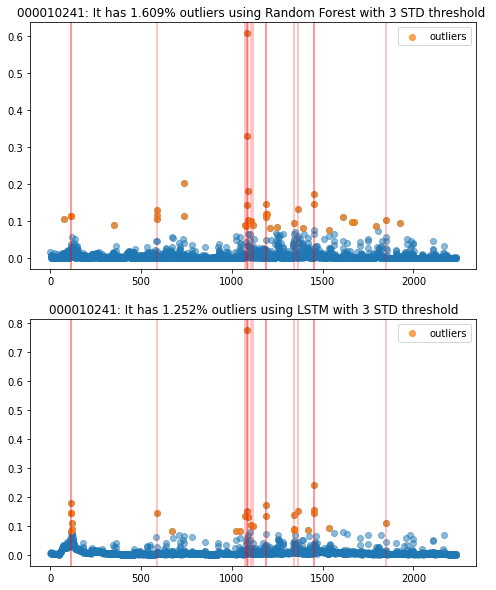

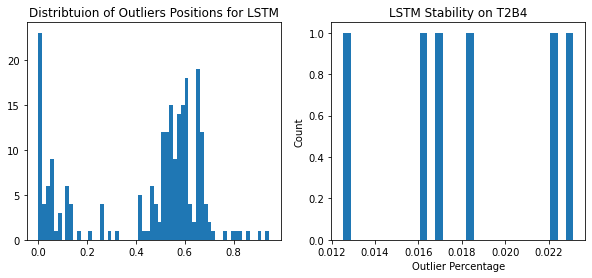

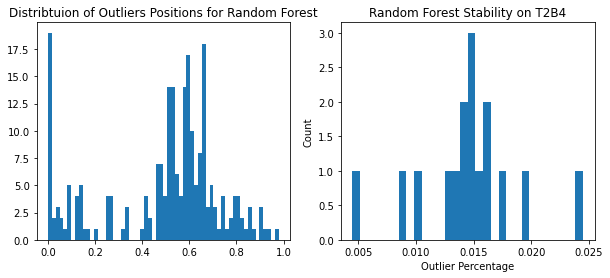

In [175]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T2B4:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T2B4')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T2B4')
plt.show()

In [177]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000002111', 0.02314410480349345),
 ('000007321', 0.022222222222222223),
 ('000007341', 0.0182956186807896),
 ('000003141', 0.017057569296375266),
 ('000004141', 0.016177957532861477),
 ('000010241', 0.012516763522574878)]

In [178]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000007321', 0.02280701754385965),
 ('000004141', 0.020728008088978768),
 ('000002111', 0.02052401746724891),
 ('000003141', 0.017484008528784647),
 ('000010241', 0.016092981671881983),
 ('000007341', 0.012999518536350506)]

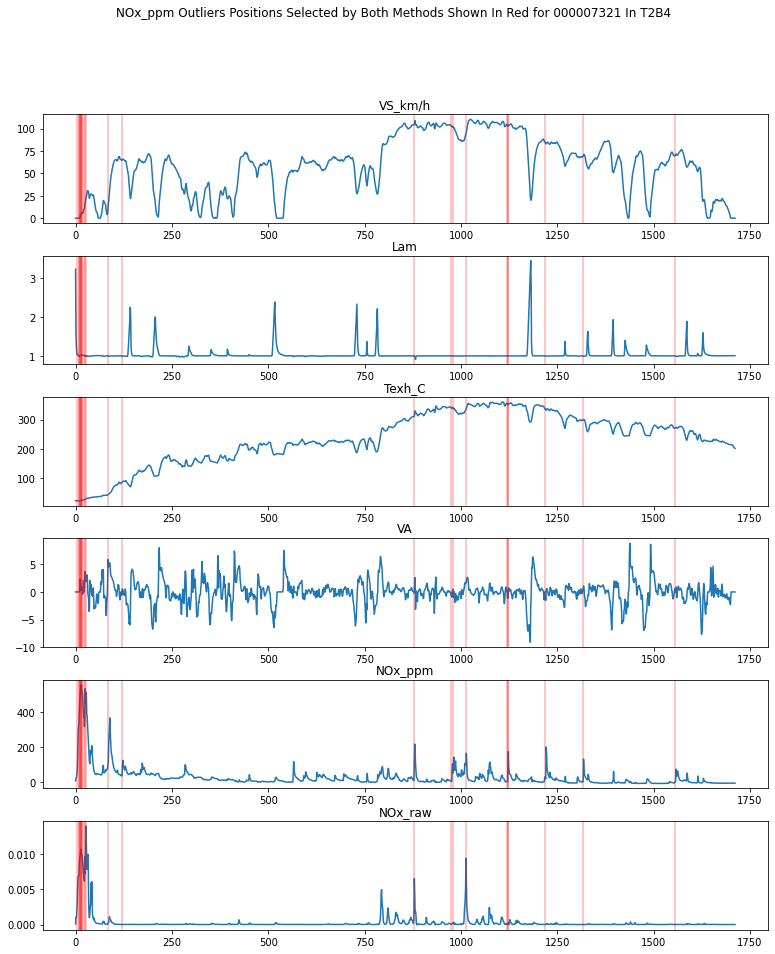

In [179]:
record = '000007321'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T2B4")
plt.show()

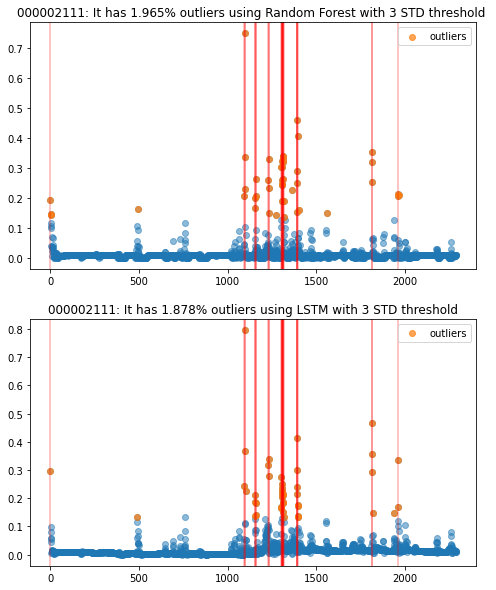

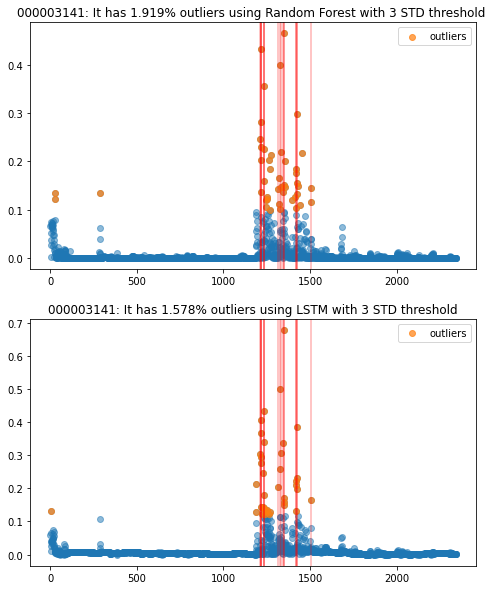

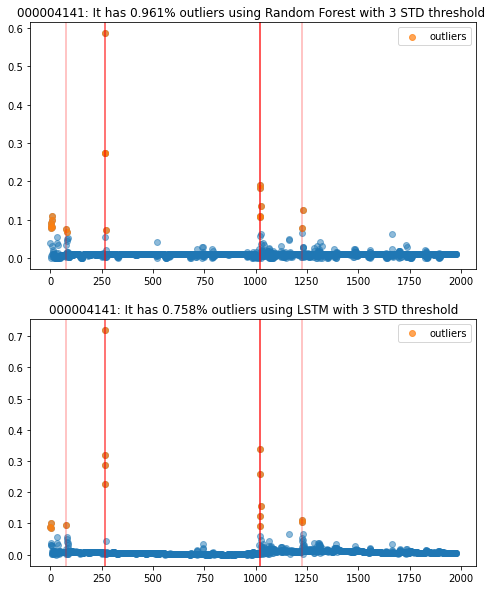

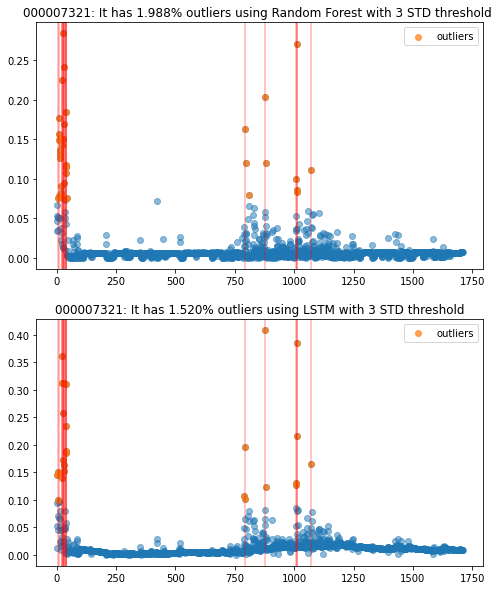

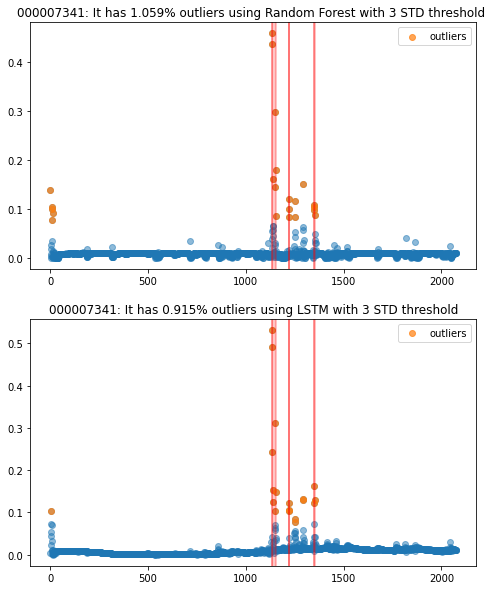

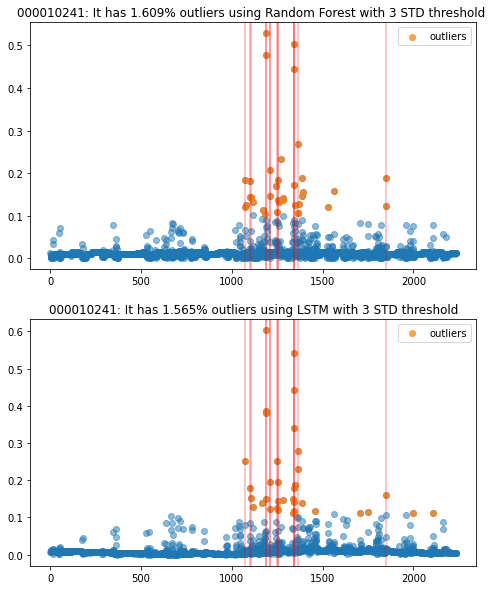

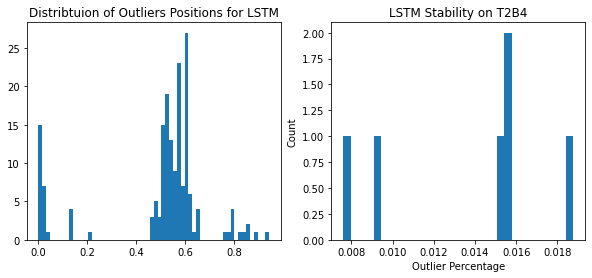

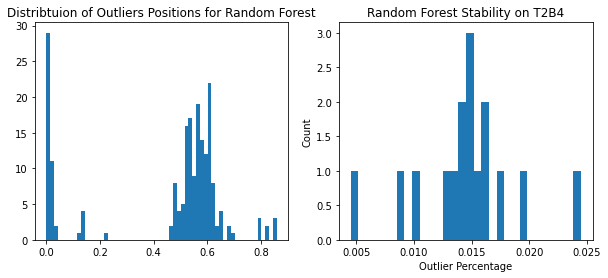

In [180]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T2B4:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T2B4')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T2B4')
plt.show()

In [181]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000002111', 0.018777292576419215),
 ('000003141', 0.01577825159914712),
 ('000010241', 0.015645954403218598),
 ('000007321', 0.0152046783625731),
 ('000007341', 0.0091478093403948),
 ('000004141', 0.007583417593528817)]

In [182]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000007321', 0.019883040935672516),
 ('000002111', 0.019650655021834062),
 ('000003141', 0.019189765458422176),
 ('000010241', 0.016092981671881983),
 ('000007341', 0.01059220028887819),
 ('000004141', 0.009605662285136502)]

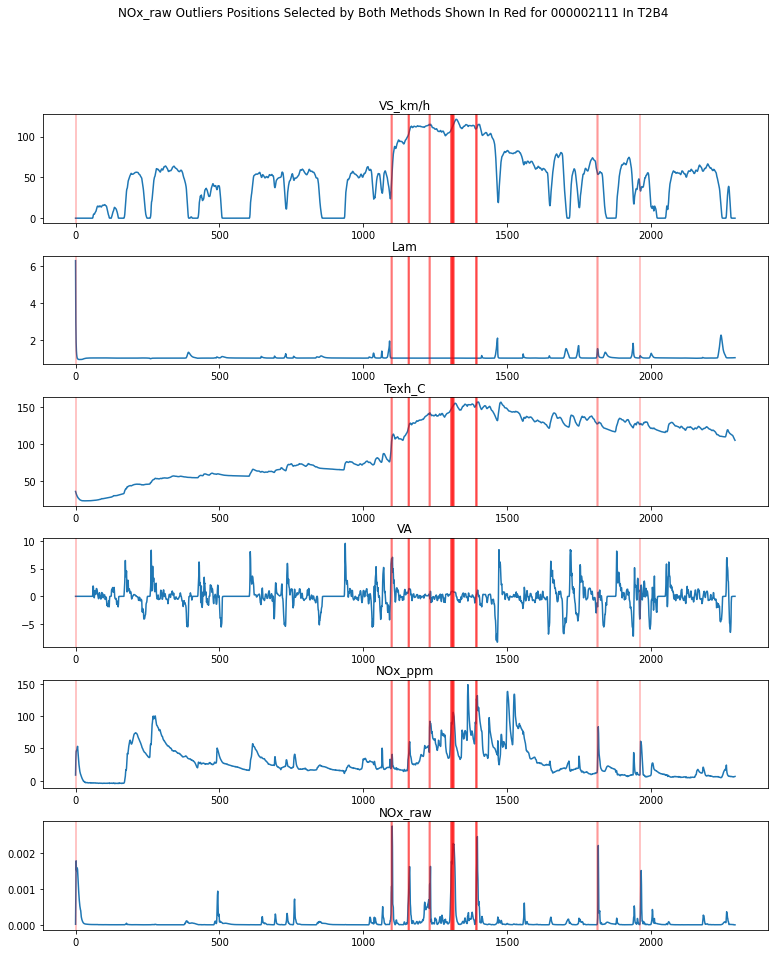

In [183]:
record = '000002111'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T2B4")
plt.show()

# T3B125

In [211]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T3B125 = record[record.Standard == 'T3B125'].RecordID.values
T3B125 = [str(i).zfill(9) for i in T3B125]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T3B125[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T3B125[0]]*len(df)
for record in T3B125[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df = new_df.dropna()
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

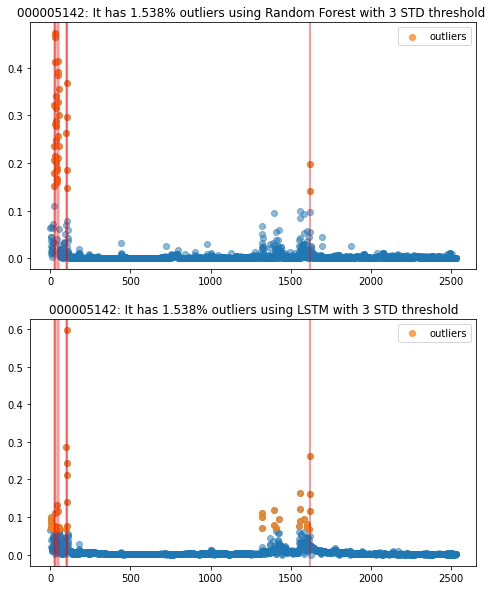

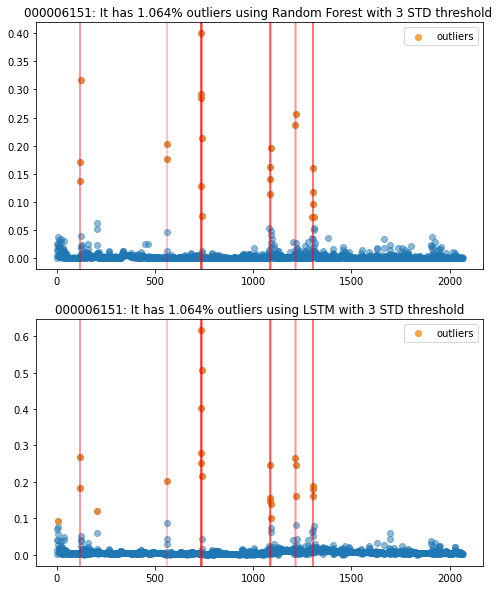

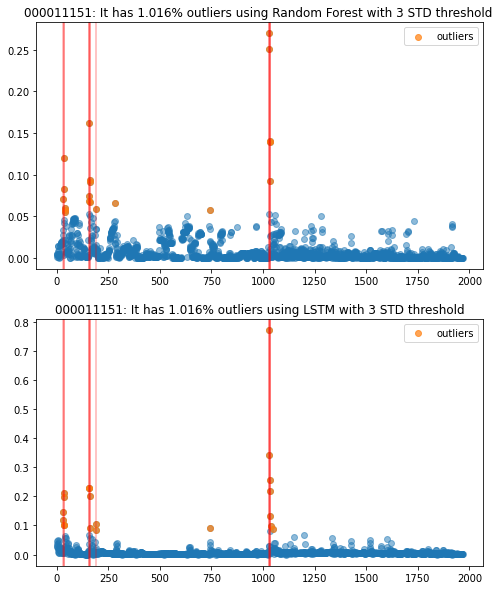

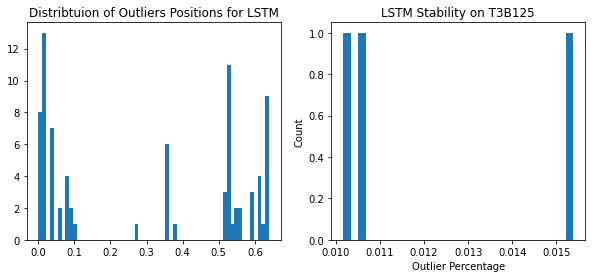

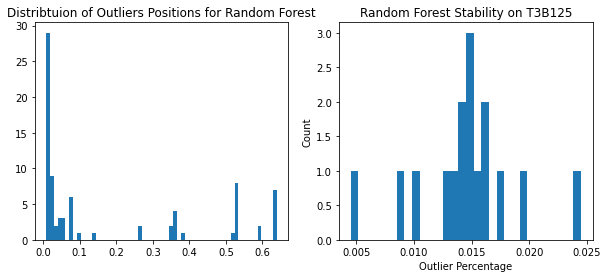

In [203]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B125:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B125')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B125')
plt.show()

In [204]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000005142', 0.015384615384615385),
 ('000006151', 0.010643444605708756),
 ('000011151', 0.01016260162601626)]

In [205]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000005142', 0.015384615384615385),
 ('000006151', 0.010643444605708756),
 ('000011151', 0.01016260162601626)]

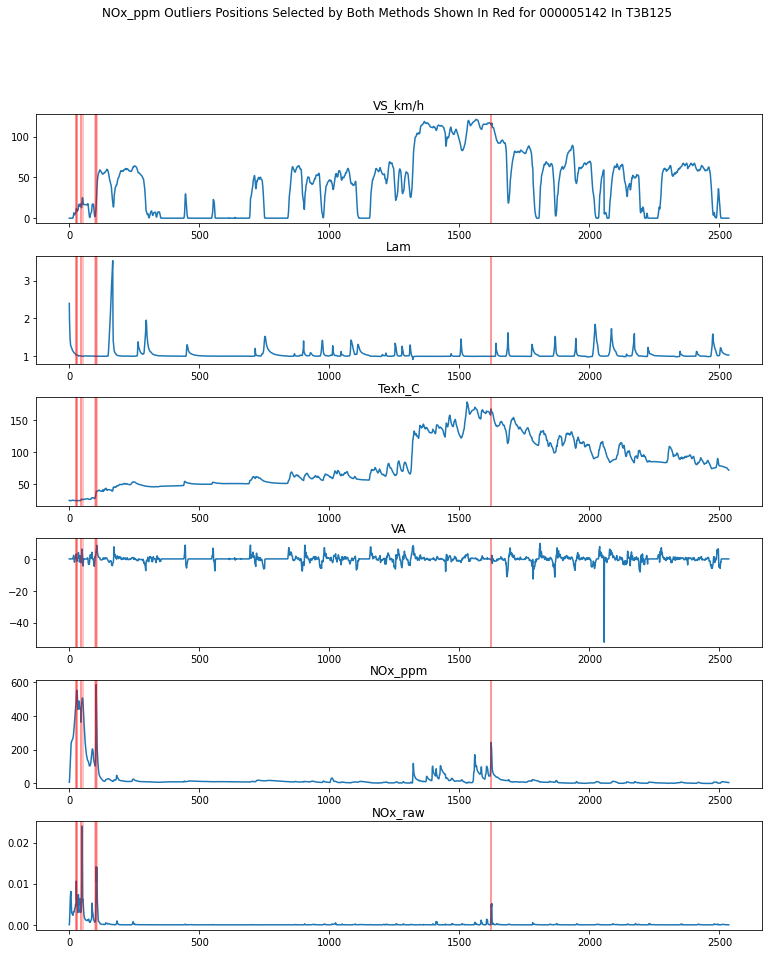

In [206]:
record = '000005142'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B125")
plt.show()

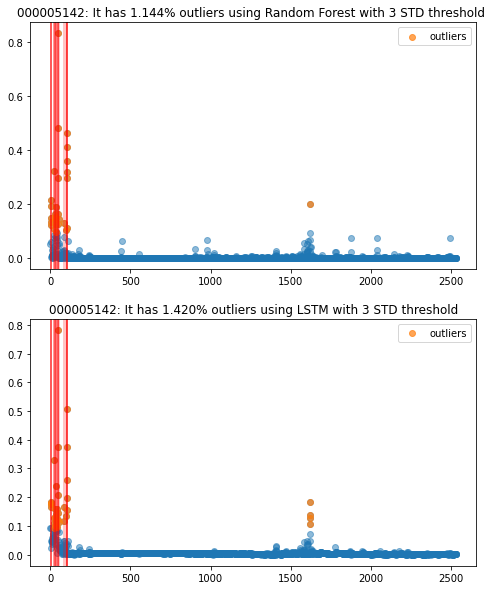

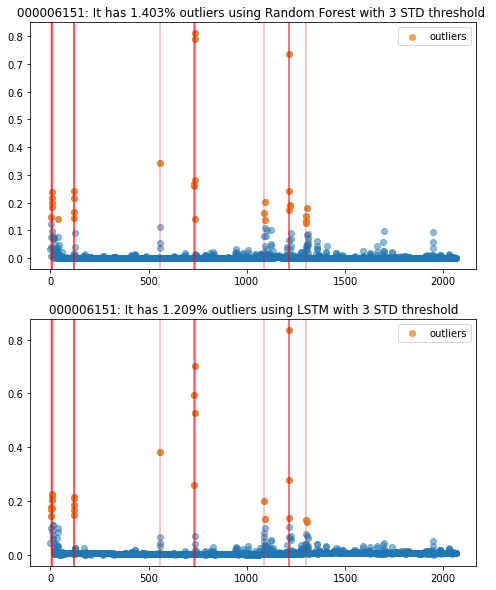

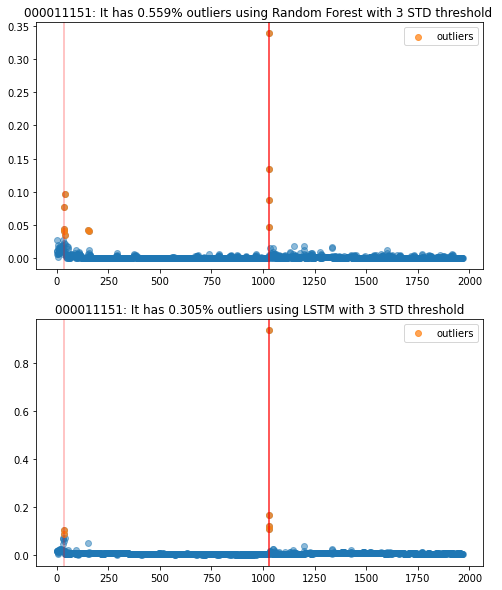

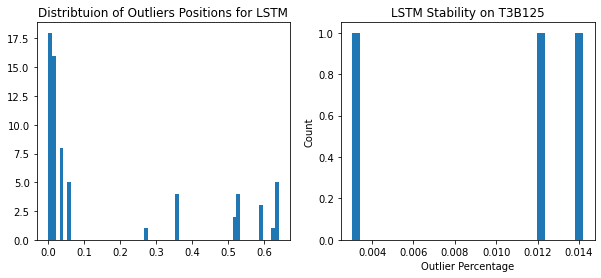

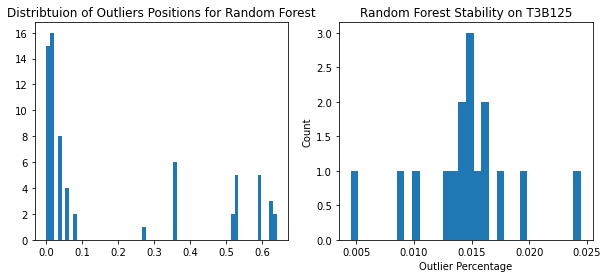

In [207]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B125:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B125')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B125')
plt.show()

In [208]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000005142', 0.014201183431952662),
 ('000006151', 0.012094823415578132),
 ('000011151', 0.003048780487804878)]

In [209]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000006151', 0.014029995162070633),
 ('000005142', 0.011439842209072978),
 ('000011151', 0.005589430894308943)]

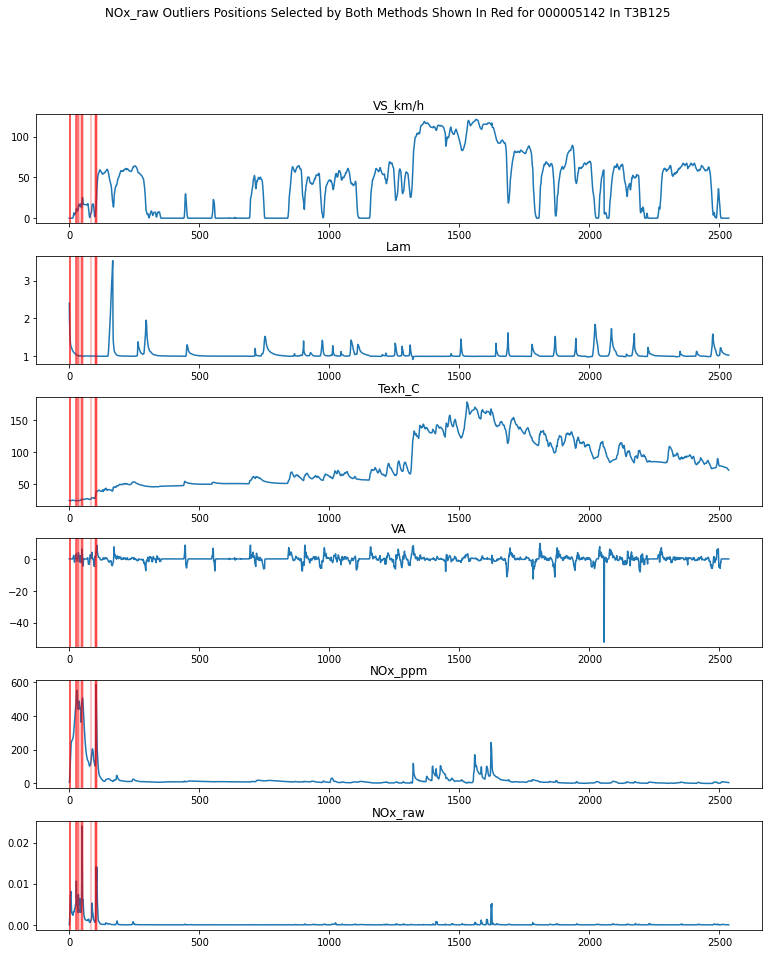

In [210]:
record = '000005142'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B125")
plt.show()

# T2B3

In [218]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T2B3 = record[record.Standard == 'T2B3'].RecordID.values
T2B3 = [str(i).zfill(9) for i in T2B3]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T2B3[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T2B3[0]]*len(df)
for record in T2B3[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df = new_df.dropna()
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

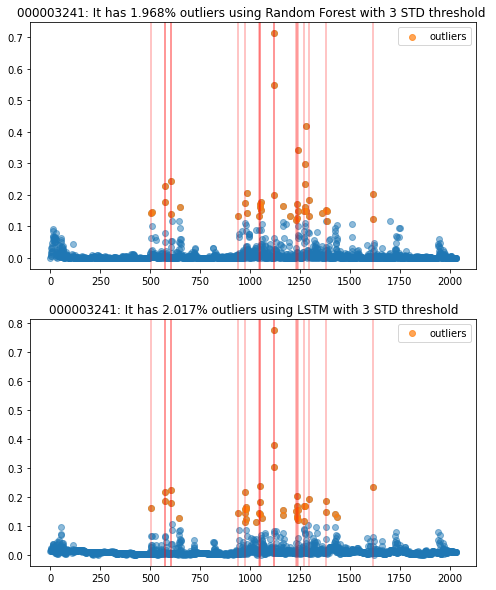

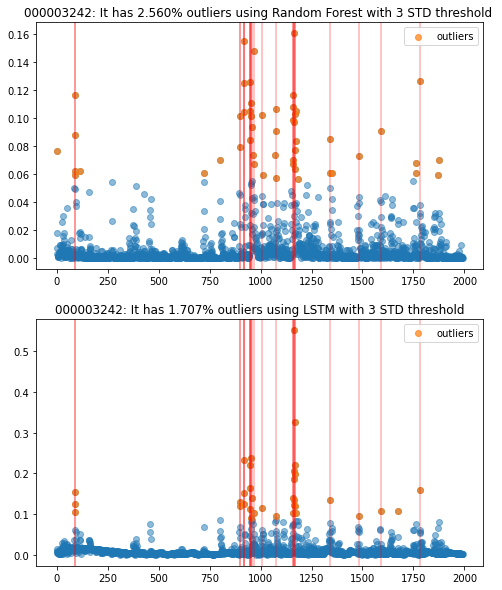

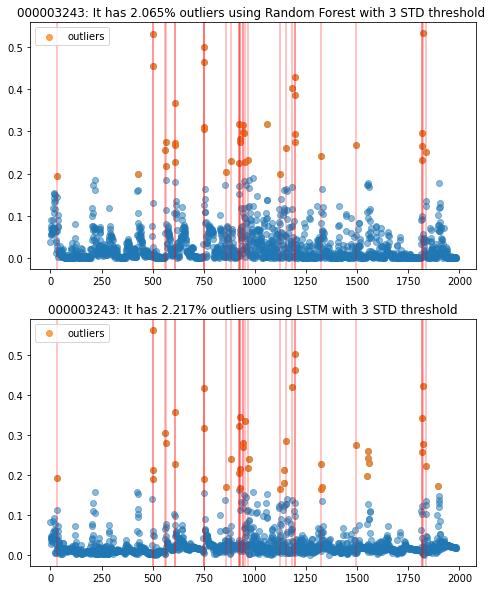

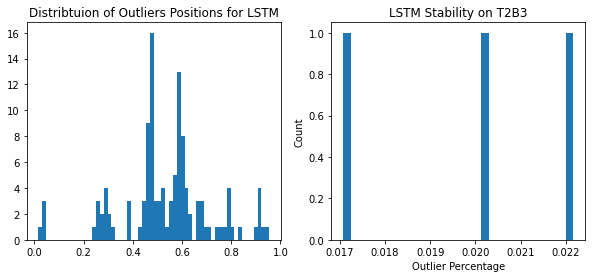

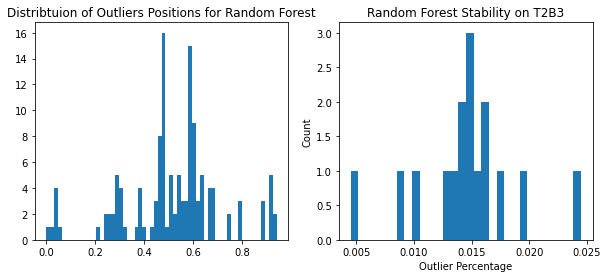

In [219]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T2B3:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T2B3')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T2B3')
plt.show()

In [220]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000003243', 0.02216624685138539),
 ('000003241', 0.02016724053123463),
 ('000003242', 0.01706827309236948)]

In [221]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000003242', 0.025602409638554216),
 ('000003243', 0.02065491183879093),
 ('000003241', 0.019675356615838663)]

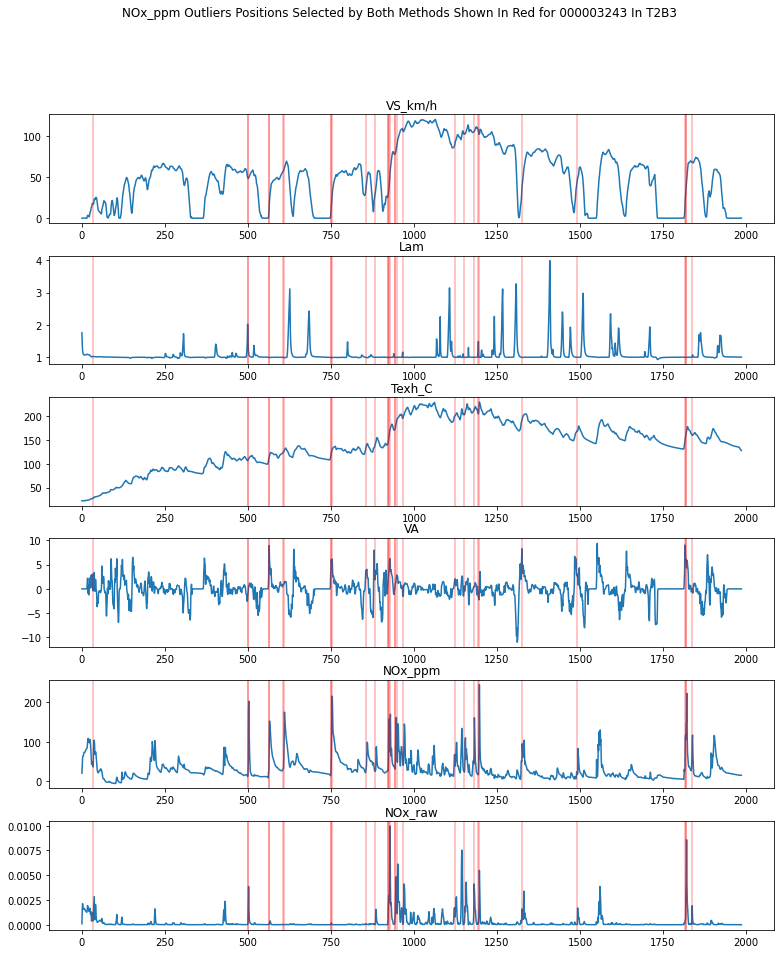

In [222]:
record = '000003243'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T2B3")
plt.show()

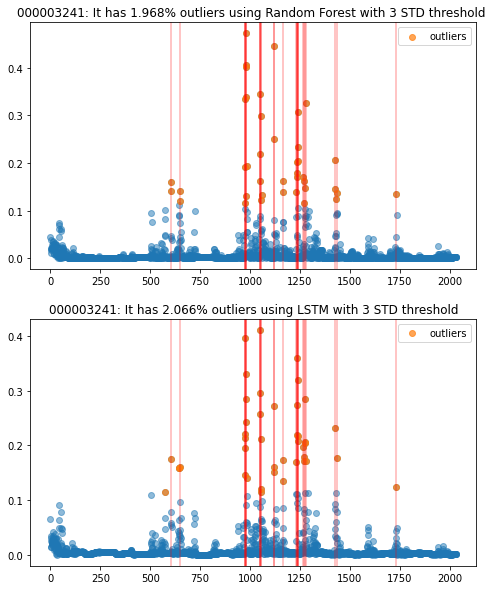

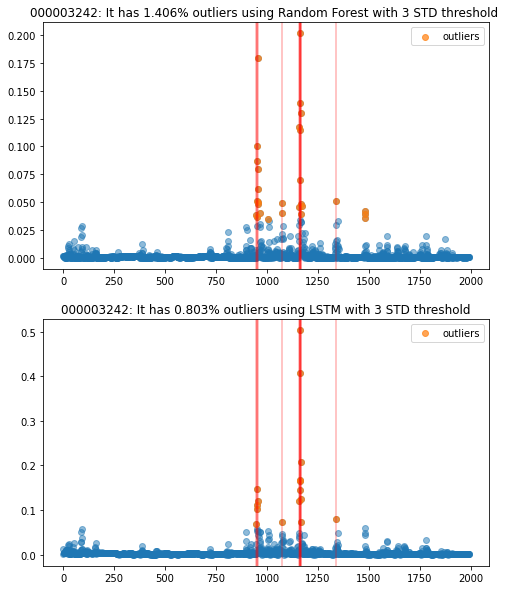

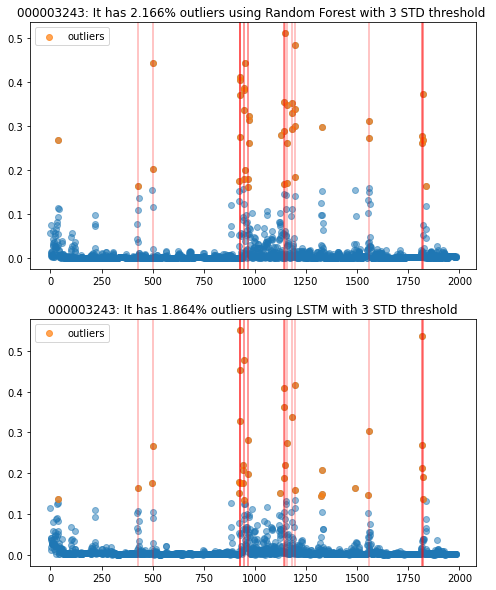

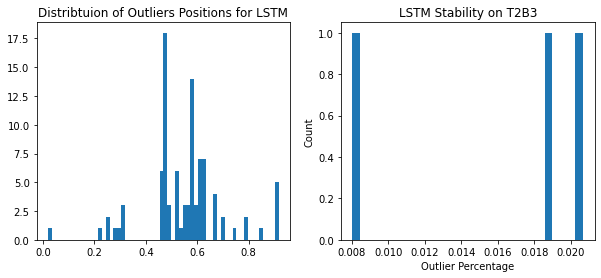

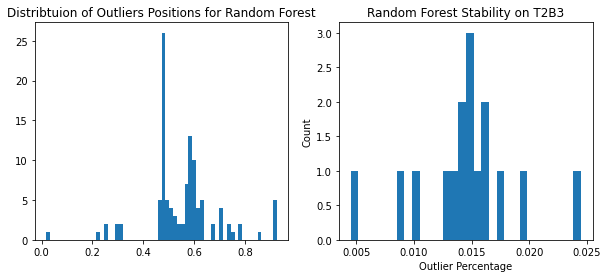

In [223]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T2B3:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T2B3')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T2B3')
plt.show()

In [224]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000003241', 0.020659124446630595),
 ('000003243', 0.018639798488664986),
 ('000003242', 0.008032128514056224)]

In [225]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000003243', 0.021662468513853905),
 ('000003241', 0.019675356615838663),
 ('000003242', 0.014056224899598393)]

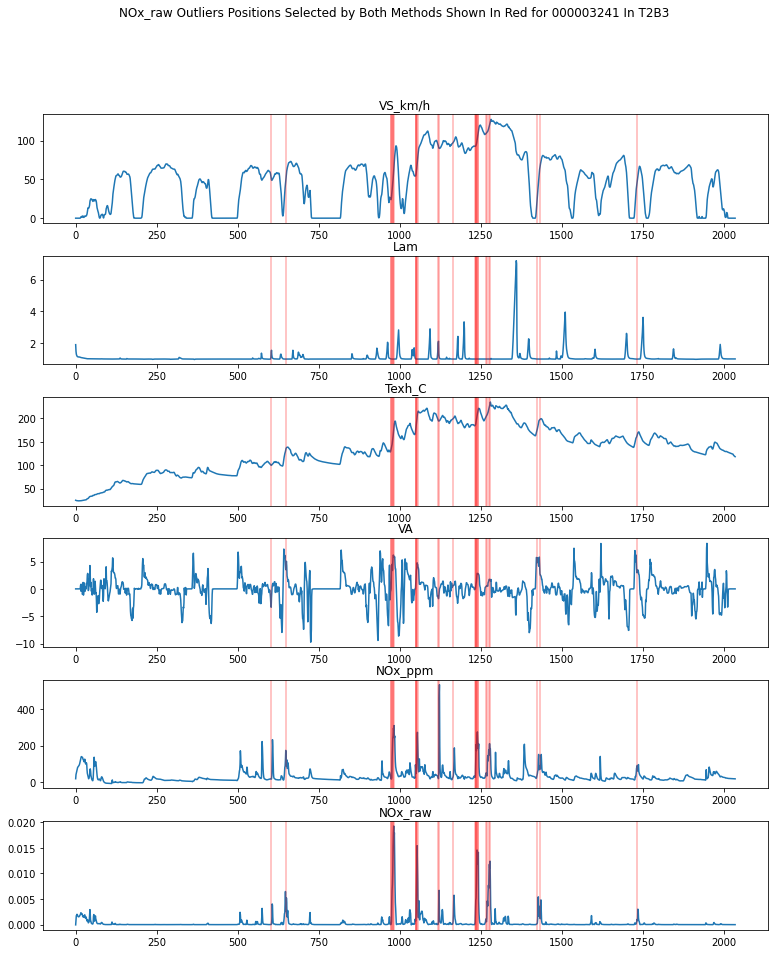

In [226]:
record = '000003241'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T2B3")
plt.show()

# T3B70

In [227]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T3B70 = record[record.Standard == 'T3B70'].RecordID.values
T3B70 = [str(i).zfill(9) for i in T3B70]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T3B70[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T3B70[0]]*len(df)
for record in T3B70[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df = new_df.dropna()
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

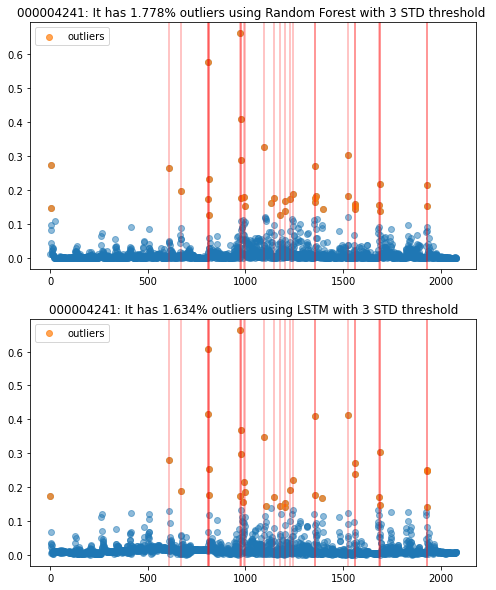

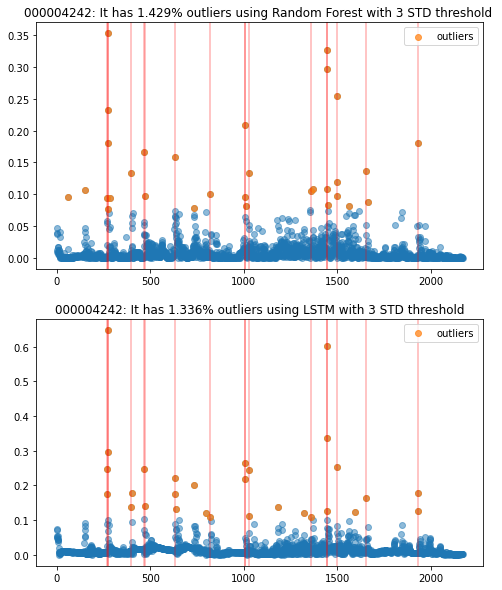

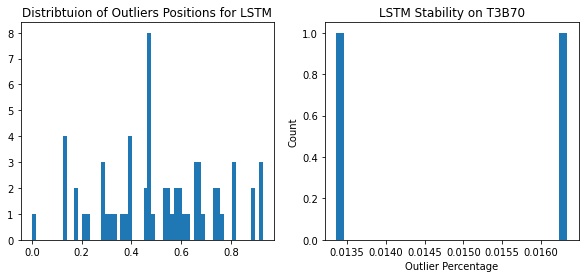

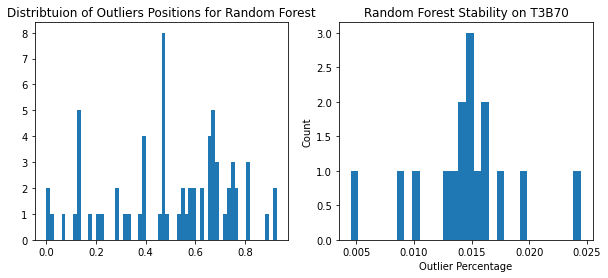

In [228]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B70:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B70')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B70')
plt.show()

In [229]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000004241', 0.016338298894762134), ('000004242', 0.013364055299539171)]

In [230]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000004241', 0.0177799135031235), ('000004242', 0.014285714285714285)]

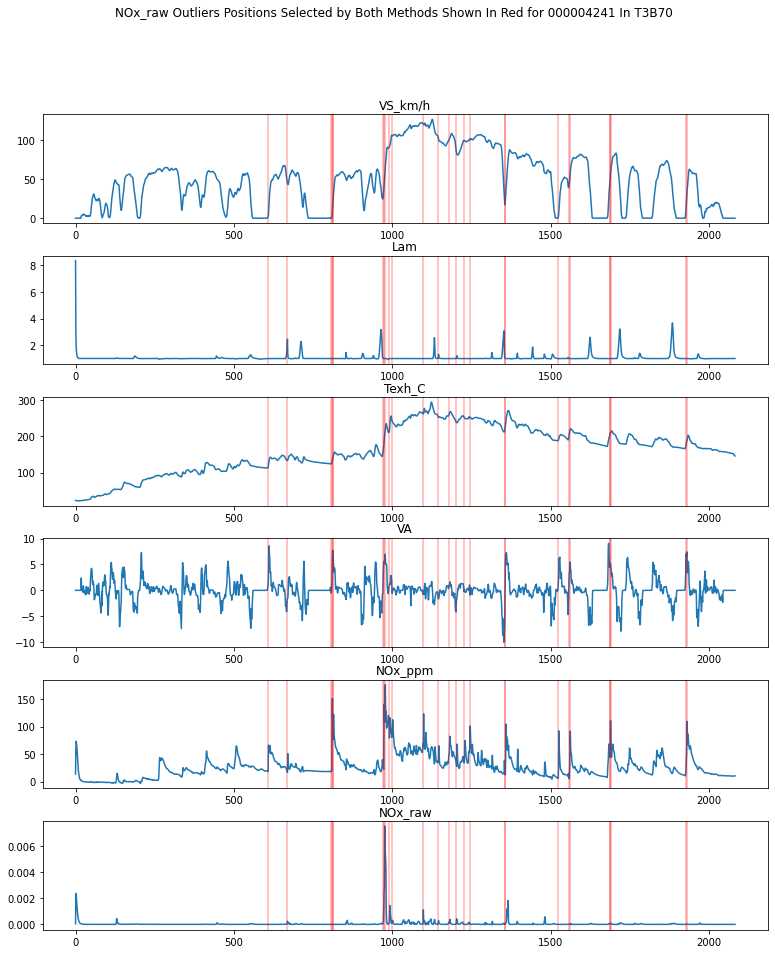

In [231]:
record = '000004241'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B70")
plt.show()

# T3B30

In [232]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T3B30 = record[record.Standard == 'T3B30'].RecordID.values
T3B30 = [str(i).zfill(9) for i in T3B30]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T3B30[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T3B30[0]]*len(df)
for record in T3B30[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df = new_df.dropna()
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

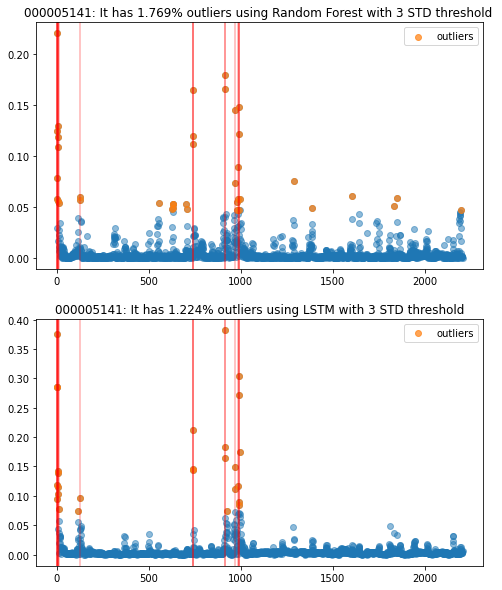

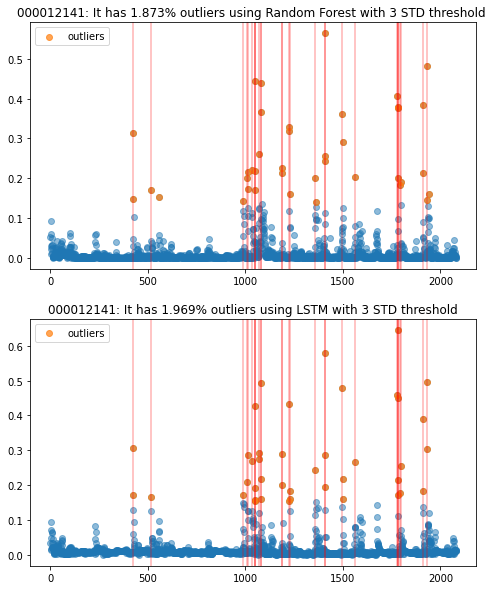

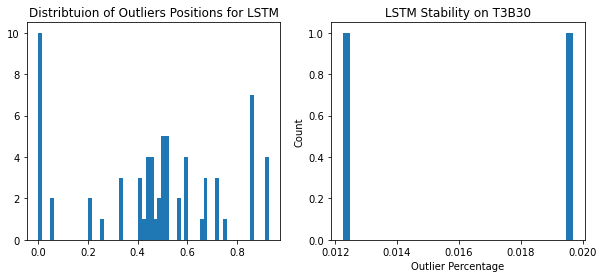

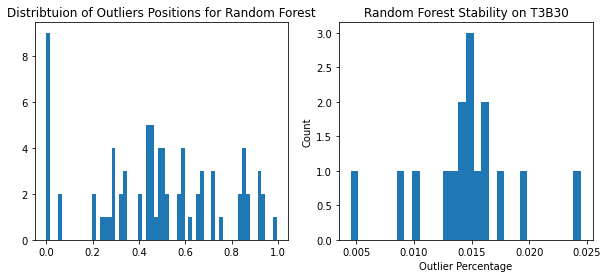

In [233]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B30:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B30')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B30')
plt.show()

In [234]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000012141', 0.0196926032660903), ('000005141', 0.012244897959183673)]

In [235]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000012141', 0.018731988472622477), ('000005141', 0.017687074829931974)]

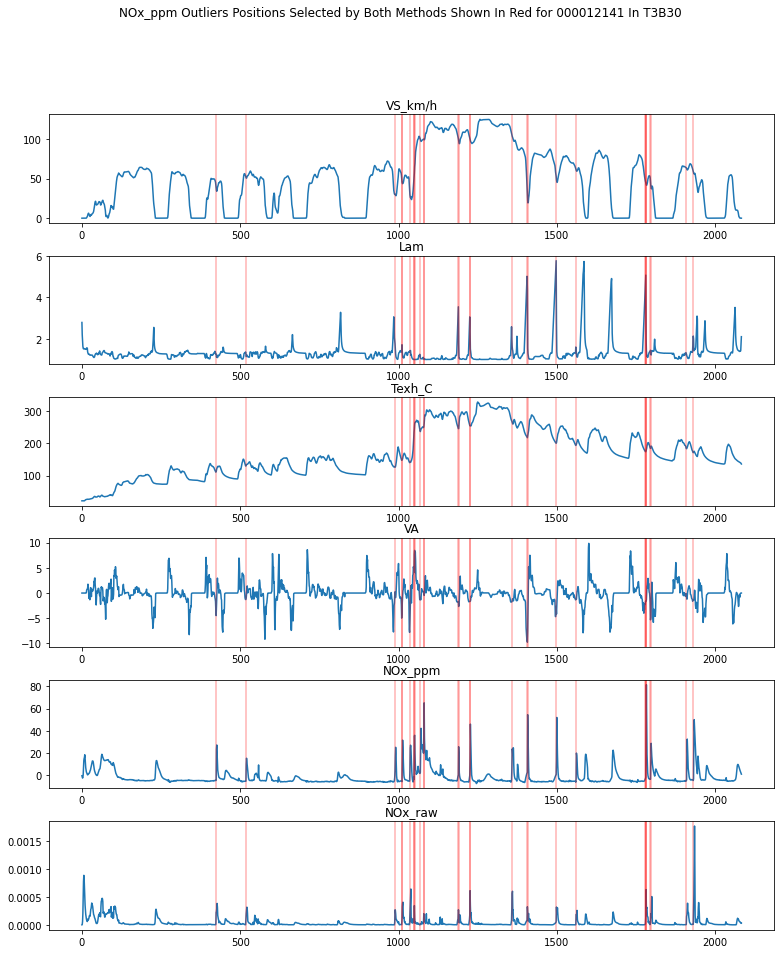

In [236]:
record = '000012141'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B30")
plt.show()

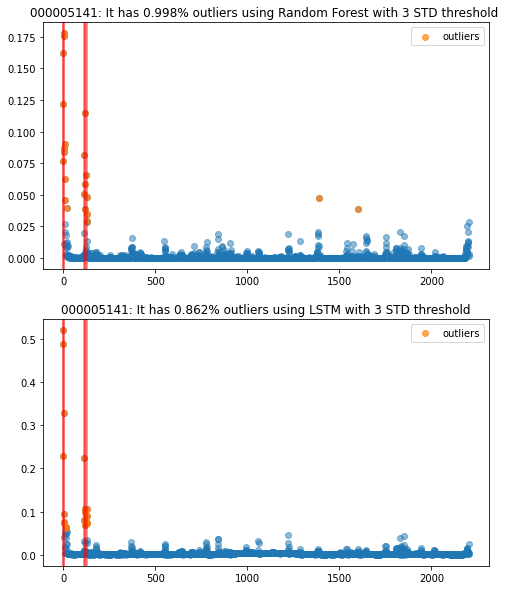

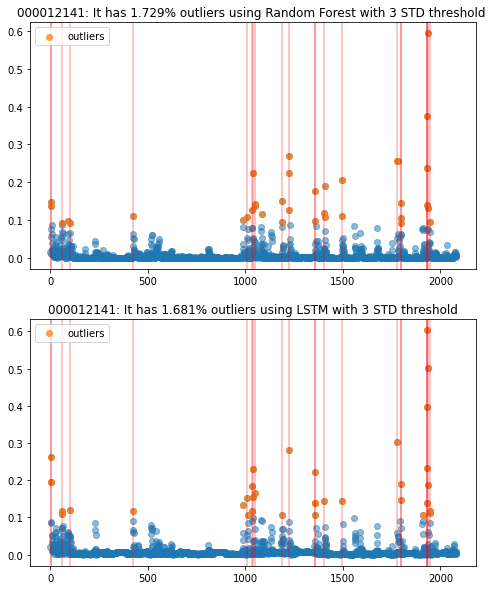

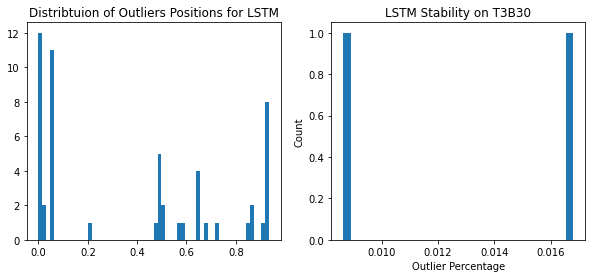

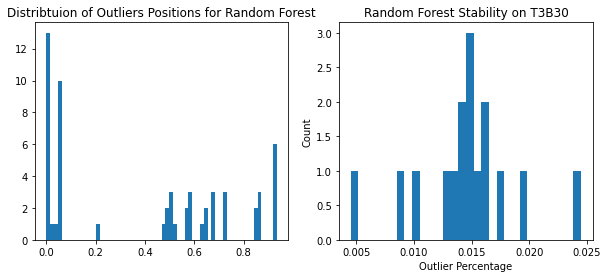

In [237]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B30:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B30')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B30')
plt.show()

In [238]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000012141', 0.01681075888568684), ('000005141', 0.008616780045351474)]

In [239]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000012141', 0.01729106628242075), ('000005141', 0.009977324263038548)]

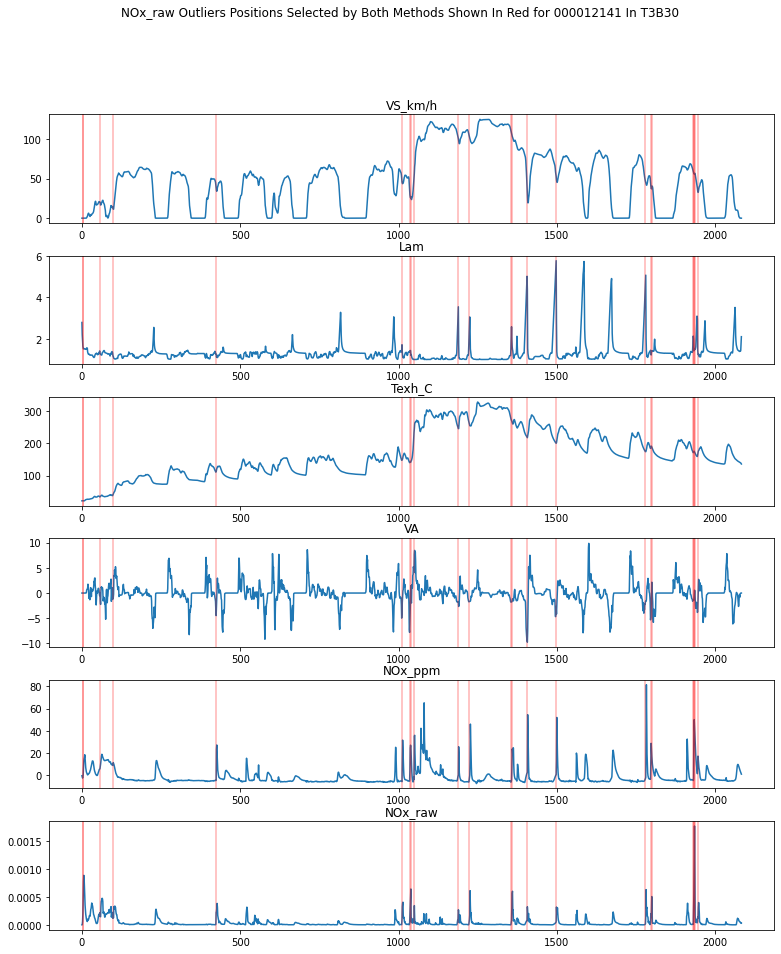

In [240]:
record = '000012141'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B30")
plt.show()

# T3B85      

In [241]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T3B85 = record[record.Standard == 'T3B85'].RecordID.values
T3B85 = [str(i).zfill(9) for i in T3B85]

df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T3B85[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
df['record'] = [T3B85[0]]*len(df)
for record in T3B85[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm','NOx_raw']]
    new_df = new_df.dropna()
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

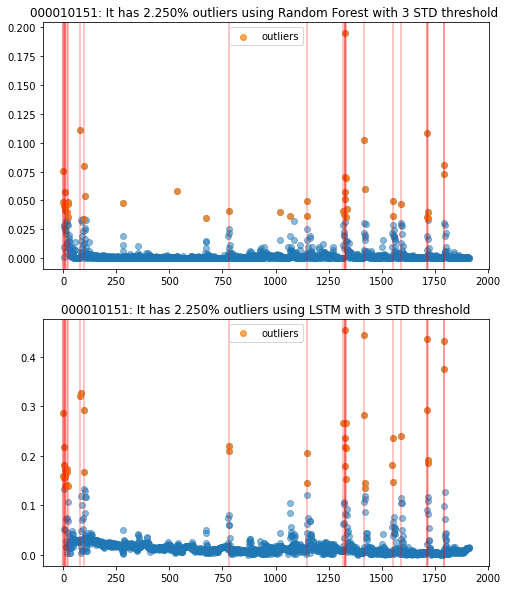

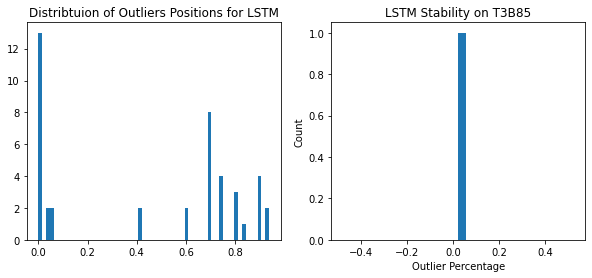

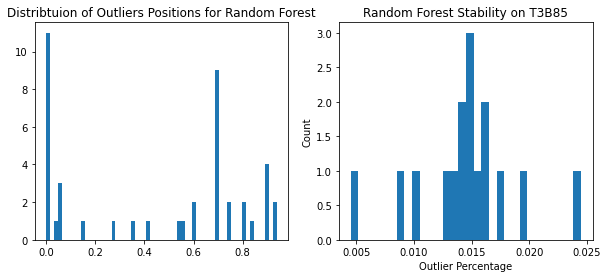

In [242]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B85:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_ppm']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B85')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B85')
plt.show()

In [243]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000010151', 0.02250130821559393)]

In [244]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000010151', 0.02250130821559393)]

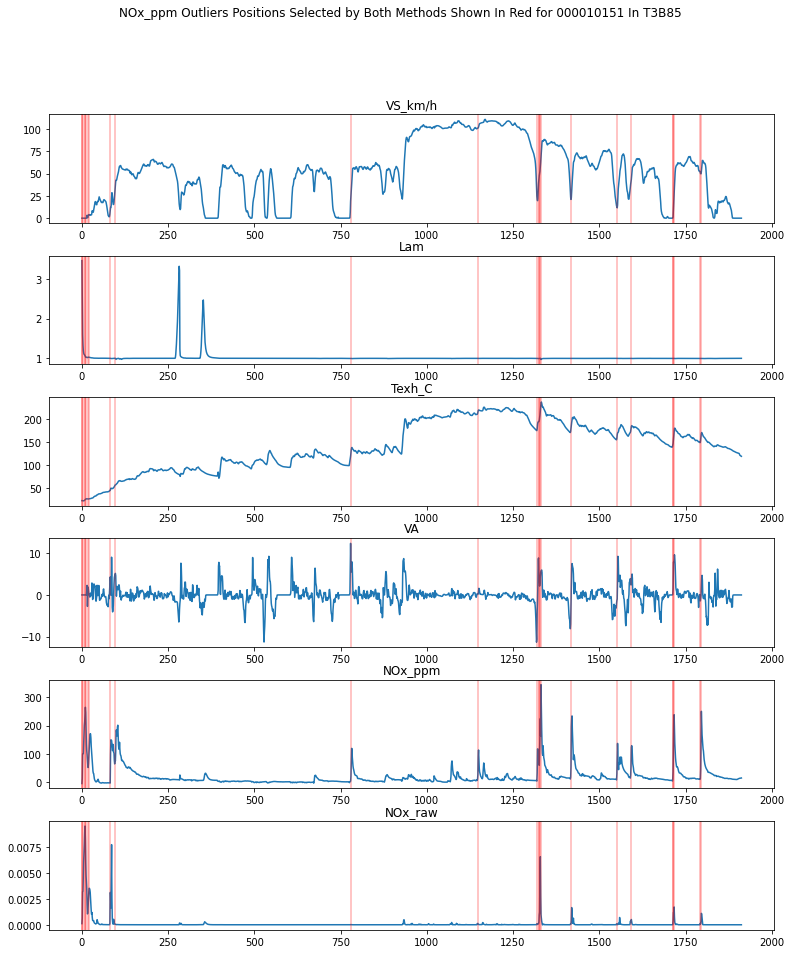

In [245]:
record = '000010151'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B85")
plt.show()

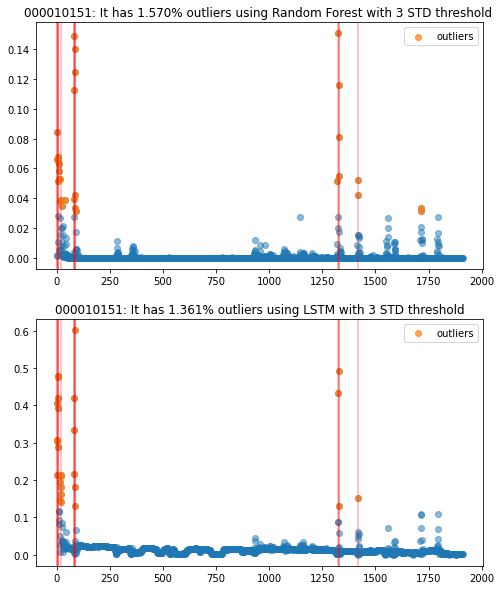

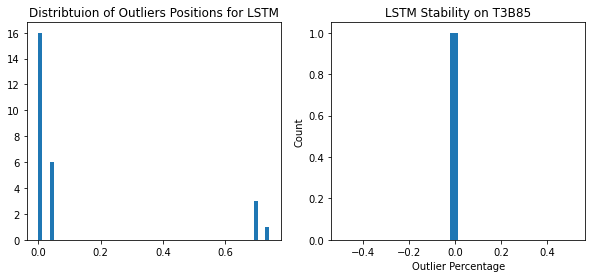

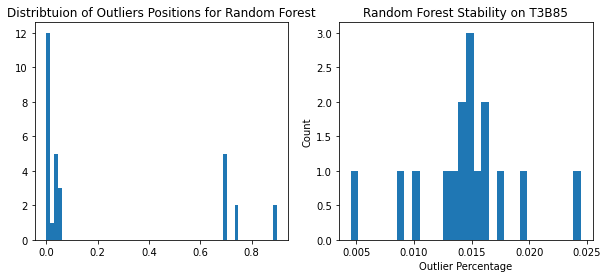

In [246]:
lag = 2
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(lag, 5)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')

# Train both LSTM and RF
train_values = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)
rf_model.fit(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], lag, -1))
lstm_model.fit(train_X, train_y, epochs=30, batch_size=72, shuffle=False, verbose=0)

ppm_diff_percent = []
ppm_out_pos = []

rf_ppm_diff_perc = []
rf_ppm_out_pos = []

threshold = 3

ppm_true_out = []
for record in T3B85:
    values = df[df.record==record][['VS_km/h','Lam','Texh_C','VA','NOx_raw']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    
    fig,ax = plt.subplots(2,figsize=(8,10))
    
    #get info for RF
    rf_pred = rf_model.predict(X).reshape(-1)
    rf_diff = abs(rf_pred - y)
    bar = np.mean(rf_diff) + threshold*np.std(rf_diff)
    rf_outliers_pos = np.where(rf_diff > bar)[0]
    rf_ppm_out_pos.append((record, rf_outliers_pos/len(y)))
    per = len(rf_outliers_pos)/len(y)
    rf_ppm_diff_perc.append((record, per))
    
    ax[0].scatter(range(len(rf_diff)),rf_diff,alpha=0.5)
    ax[0].scatter(rf_outliers_pos, rf_diff[rf_outliers_pos],label='outliers', alpha=0.7)
    ax[0].set_title(f'{record}: It has {per * 100:.3f}% outliers using Random Forest with {threshold} STD threshold ')
    ax[0].legend()
    
    #get info for LSTM
    X = X.reshape((X.shape[0], lag, -1))
    predicted = lstm_model.predict(X).reshape(-1)
    lstm_diff = abs(predicted - y)
    bar = np.mean(lstm_diff) + threshold*np.std(lstm_diff)
    lstm_outliers_pos = np.where(lstm_diff > bar)[0]
    ppm_out_pos.append((record, lstm_outliers_pos/len(y)))
    per = len(lstm_outliers_pos)/len(y)
    ppm_diff_percent.append((record, per))
    
    ax[1].scatter(range(len(lstm_diff)),lstm_diff,alpha=0.5)
    ax[1].scatter(lstm_outliers_pos, lstm_diff[lstm_outliers_pos],label='outliers', alpha=0.7)
    ax[1].set_title(f'{record}: It has {per * 100:.3f}% outliers using LSTM with {threshold} STD threshold')    
    ax[1].legend()
    
    #common
    com = np.intersect1d(lstm_outliers_pos,rf_outliers_pos)
    ppm_true_out.append((record,com))
    for i in com:
        ax[0].axvline(i,color='r',alpha=0.3)
        ax[1].axvline(i,color='r',alpha=0.3)
    plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for LSTM')
ax[1].hist([i[1] for i in ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'LSTM Stability on T3B85')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
t = [i[1] for i in rf_ppm_out_pos]
ax[0].hist([item for sublist in t for item in sublist], bins=60)
ax[0].set_title('Distribtuion of Outliers Positions for Random Forest')

ax[1].hist([i[1] for i in rf_ppm_diff_percent], bins=30)
ax[1].set_xlabel('Outlier Percentage')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Random Forest Stability on T3B85')
plt.show()

In [247]:
ppm_diff_percent.sort(key = lambda x:-x[1])
ppm_diff_percent

[('000010151', 0.013605442176870748)]

In [248]:
rf_ppm_diff_perc.sort(key = lambda x:-x[1])
rf_ppm_diff_perc

[('000010151', 0.015698587127158554)]

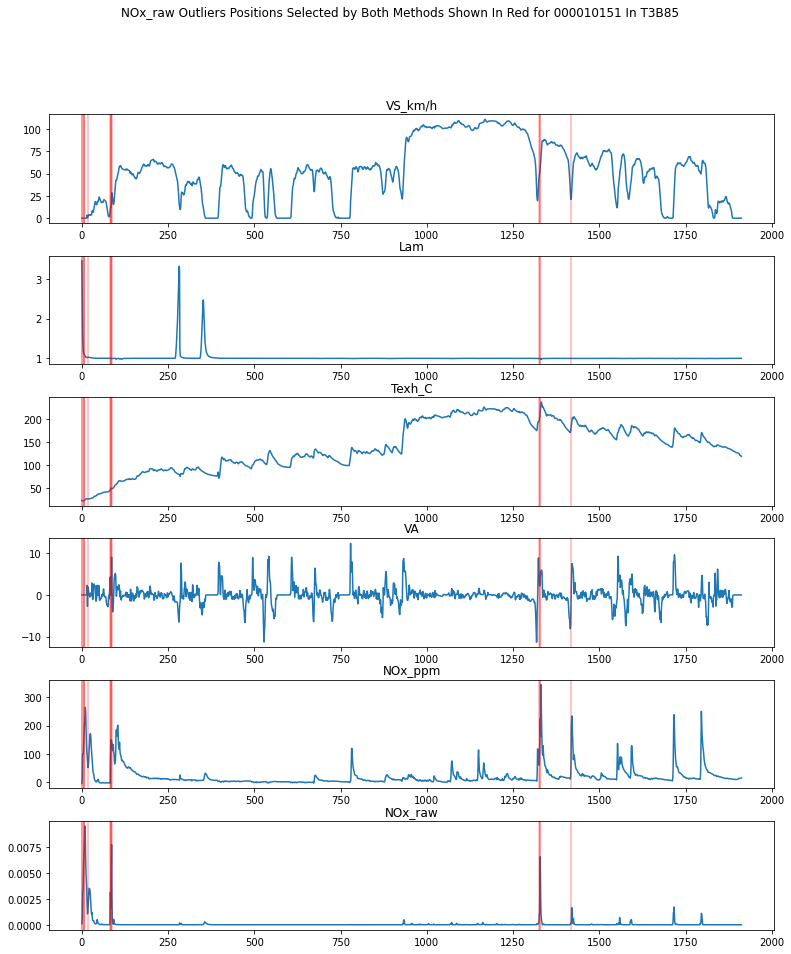

In [249]:
record = '000010151'
temp_pos = [i[0] for i in ppm_true_out].index(record)
temp = df[df.record==record]
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(range(len(temp)), temp.iloc[:, i])
    axes[i].set_title(temp.columns[i])
    for pos in ppm_true_out[temp_pos][1]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Selected by Both Methods Shown In Red for "+record+" In T3B85")
plt.show()